## Исследование источников трафика

## Описание проекта

Для отдела маркетинговой аналитики Яндекс.Афиши необходимо подготовить отчёт, который поможет маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

В процессе исследования необходимо изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.

## <a name="0"> Структура проекта </a>

Исследование содержит следущие главы:
- [Загрузка данных и ознакомление с ними](#1)
  - [Таблица visits](#2)
  - [Таблица orders](#3)
  - [Таблица costs](#4)
- [Предобработка данных](#5)
- [Продуктовые метрики](#6)
  - [Метрики DAU, WAU и MAU](#7)
  - [Среднее количество посещений сайта пользователем в сутки](#8)
  - [Продолжительность пользовательской сессии (ASL)](#9)
  - [Когортный анализ и Retention Rate](#10)
  - [Выводы по продуктовым метрикам](#11)
- [Метрики электронной коммерции](#12)
  - [Среднее время на покупку](#13)
  - [Среднее количество покупок](#14)
  - [Средняя выручка с покупателя](#15)
  - [Средний чек](#16)
  - [Выводы по метрикам электронной коммерции](#17)
- [Маркетинговые метрики](#18)
  - [Расходы на маркетинг](#19)
  - [Метрика CAC](#20)
  - [Метрика ROMI](#21)
  - [Выводы по маркетинговым метрикам](#22)
- [Общий вывод и рекомендации](#23)

## <a name="1"> Загрузка данных и ознакомление с ними </a>

Импортируем необходимые библиотеки для работы с табличными данными и визуализации:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None) # команда позволит выводить все столбцы таблицы, если их много, без сокращения

Загрузим три таблицы, которые содержат: 
- лог сервера с данными о посещениях сайта Яндекс.Афиши;
- выгрузка всех заказов за этот период;
- статистика рекламных расходов.

Названия таблиц visits, orders и costs.

In [3]:
visits = pd.read_csv('/Users/polzovatel/Desktop/visits_log.csv')
orders = pd.read_csv('/Users/polzovatel/Desktop/orders_log.csv')
costs = pd.read_csv('/Users/polzovatel/Desktop/costs.csv')

Датасет с данными можно скачать с google диска, он размещён [здесь](https://drive.google.com/drive/folders/1Iuxzqgk8Dw3V3wEpT_MphCWsSjrYJbSP?usp=sharing).

### <a name="2"> Таблица visits </a>

Посмотрим на таблицу visits:

In [4]:
visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
124133,desktop,2017-12-07 16:02:00,1,2017-12-07 16:00:00,12318346375502220837
287829,desktop,2018-01-05 23:55:00,4,2018-01-05 23:52:00,13488464873518671318
254892,desktop,2018-05-24 20:02:00,4,2018-05-24 19:52:00,11434816550644396137
57691,touch,2017-07-04 03:55:00,3,2017-07-04 03:53:00,16766167451422499540
200490,desktop,2017-08-24 09:45:00,4,2017-08-24 09:45:00,1238801420910111037


В столбцах таблицы содержится следующая информация:
- Device - с какого устройства заходил пользователь;
- Start Ts - начало сессии;
- End Ts - конец сессии;
- Source Id - источник пользователя;
- Uid - уникальный id пользователя.

Посмотрим на типы данных в столбцах и оценим количество пропусков:

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Оценим интервал времени, за которые были посещения:

In [6]:
visits['Start Ts'].min(), visits['Start Ts'].max()

('2017-06-01 00:01:00', '2018-05-31 23:59:00')

Посчитаем количество уникальных пользователей, которые посещали сайт:

In [7]:
total_visitors = visits.Uid.nunique()
total_visitors

228169

Посчитаем, сколько в среднем пользователь совершил посещений за год:

In [8]:
len(visits) / total_visitors

1.5751482453795214

Посмотрим на типы устройств, с которых заходят пользователи, и частоту их использования:

In [9]:
visits.Device.value_counts()

desktop    262567
touch       96833
Name: Device, dtype: int64

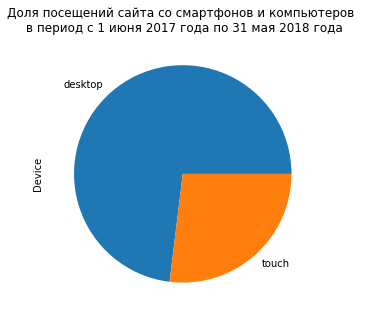

In [10]:
visits.Device.value_counts().plot(kind='pie', figsize=(5, 5))
plt.title("Доля посещений сайта со смартфонов и компьютеров \n в период с 1 июня 2017 года по 31 мая 2018 года")
plt.show()

Посмотрим на количество посещений и количество посетителей в зависимости от источника клиентов:

In [11]:
visitors_visits_by_sources = visits.groupby('Source Id').agg({'Uid': ['count', 'nunique']})
visitors_visits_by_sources.columns = ['visits', 'visitors']
visitors_visits_by_sources.loc['sum']= visitors_visits_by_sources.sum() 
visitors_visits_by_sources.T

Source Id,1,2,3,4,5,6,7,9,10,sum
visits,34121,47626,85610,101794,66905,6,36,13277,10025,359400
visitors,18999,26245,74756,83525,56974,6,34,9264,8067,277870


Сумма уникальных посетителей по источникам (277 870) оказалась больше количества уникальных посетителей (228 169), которое мы считали ранее (переменная total_users) - это значит, что некоторые посетители пришли на сайта через несколько источников.

Для наглядности построим столбиковую диаграмму количества посещений и количества посетителей для разных источников:

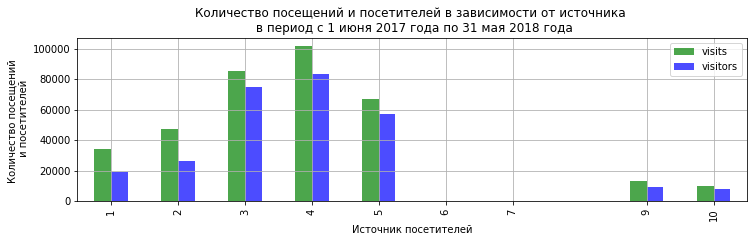

In [12]:
visitors_visits_by_sources.iloc[:-1].plot(kind='bar', grid=True, alpha=.7, figsize=(12,3), color=['g', 'b'])
plt.title("Количество посещений и посетителей в зависимости от источника \n в период \
с 1 июня 2017 года по 31 мая 2018 года")
plt.xlabel("Источник посетителей")
plt.ylabel("Количество посещений \n и посетителей")
plt.show()

Проверим, связаны ли источники клиентов с устройствами, с которых они посещают сайт. Возможно, что с определенного источника посетители приходят только, например, с мобильных устройств.

In [13]:
visits.pivot_table(index='Device', columns='Source Id', values='Uid', aggfunc='nunique')

Source Id,1,2,3,4,5,6,7,9,10
Device,,,,,,,,,
desktop,13172,18257,57420,55607,42053,5,26,7079,5763
touch,6094,8609,18600,29313,15375,1,8,2402,2381


Какой-то явной взаимосвязи не видно.

По итогам знакомства с таблицей visits можно сделать следующие выводы:
- в таблице 359 400 записей - столько было посещений сайта;
- пропусков в столбцах нет;
- интервал времени, когда были посещения, составляет один год: с 1 июня 2017 года по 31 мая 2018 года;
- всего 228 169 уникальных пользователей посещали сайт, некоторые из них пришли через несколько источников;
- в среднем они совершили 1,57 посещений сайта за год;
- пользователи используют два типа устройств: desktop (262 567 посещений) и touch (96 833 посещений);
- есть 9 источников клиентов (от 1 до 10, без 8), причем больше всего сессий у клиентов от 4 источника (101 794), а клиенты от 6 и 7 источников почти не посещали сайт;
- взаимосвязи между источниками и устройствами не наблюдается.

Необходимо провести следующую предобработку данных:
- названия столбцов содержат заглавные буквы и пробелы, нужно привести их к стилю snake_case;
- столбцы End Ts и Start Ts имеют тип данных object, нужно привести их к типу datetime.

### <a name="3"> Таблица orders </a>

Посмотрим на таблицу orders:

In [14]:
orders.sample(5)

,Buy Ts,Revenue,Uid
46976,2018-05-11 13:40:00,2.44,11276379020134363482
14536,2017-10-25 16:01:00,1.83,16069575800491663323
31549,2018-01-29 09:31:00,0.61,5114418924724793541
45429,2018-04-25 10:36:00,0.61,14538542400201263124
39162,2018-03-09 14:19:00,1.10,2259638638480130572


В столбцах таблицы содержится следующая информация:
- Buy Ts - дата и время заказа;
- Revenue - доход с заказа, у.е.;
- Uid - уникальный id пользователя.

Посмотрим на типы данных в столбцах и оценим количество пропусков:

In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Оценим интервал времени, когда были совершены заказы:

In [16]:
orders['Buy Ts'].min(), orders['Buy Ts'].max()

('2017-06-01 00:10:00', '2018-06-01 00:02:00')

Посчитаем количество уникальных пользователей, которые делали заказы:

In [17]:
total_buyers = orders.Uid.nunique()
total_buyers

36523

Посчитаем суммарную выручку, которую принесли покупатели:

In [18]:
total_revenue = orders.Revenue.sum()
total_revenue

252057.19999999998

Посмотрим на распределение выручки, которую мы получаем с одного заказа, построим гистограмму:

In [19]:
orders['Revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: Revenue, dtype: float64

In [20]:
orders['Revenue'].mode()

0    1.83
dtype: float64

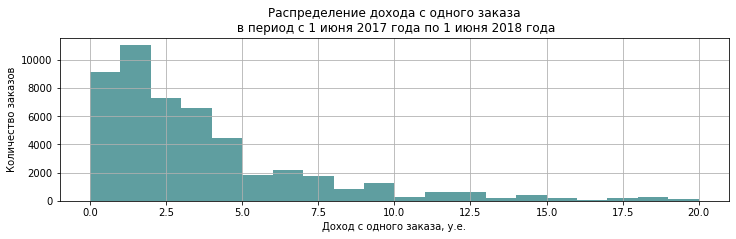

In [21]:
orders['Revenue'].hist(bins=20, range=(0, 20), figsize=(12,3), color='cadetblue')
plt.title("Распределение дохода с одного заказа\n в период с 1 июня 2017 года по 1 июня 2018 года")
plt.xlabel("Доход с одного заказа, у.е.")
plt.ylabel("Количество заказов")
plt.show()

По итогам знакомства с таблицей orders можно сделать следующие выводы:
- в таблице 50 415 записей - столько было сделано заказов;
- пропусков в столбцах нет;
- заказы были сделаны в период с 1 июня 2017 года по 1 июня 2018 года;
- всего 36 523 уникальных пользователя делали заказы;
- медианный доход с одного заказа составляет 2,5 у.е., средний доход - 5 у.е., наиболее частый доход (мода) - 1,8 у.е.; 
- встречаются выбросы, максимальный из которых - 2633,28 у.е.

Необходимо провести следующую предобработку данных:
- названия столбцов содержат заглавные буквы и пробелы, нужно привести их к стилю snake_case;
- столбцы End Ts и Start Ts имеют тип данных object, нужно привести их к типу datetime.

### <a name="4"> Таблица costs </a>

Посмотрим на таблицу costs:

In [22]:
costs.sample(5)

,source_id,dt,costs
1090,4,2017-06-02,59.21
813,3,2017-08-27,212.80
1760,5,2018-04-06,118.16
2538,10,2018-05-28,21.26
2,1,2017-06-03,36.53


В столбцах таблицы содержится следующая информация:
- source_id - источник клиентов;
- dt - дата, когда был использован источник;
- costs - рекламные расходы на источник.

Посмотрим на типы данных в столбцах и оценим количество пропусков:

In [23]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Выведем все источники клиентов, по которым были рекламные расходы:

In [24]:
sources_with_costs = costs.source_id.unique()
sources_with_costs

array([ 1,  2,  3,  4,  5,  9, 10])

Оценим интервал времени, когда были совершены рекламные расходы:

In [25]:
costs['dt'].min(), costs['dt'].max()

('2017-06-01', '2018-05-31')

Посчитаем суммарные рекламные расходы на все источники клиентов за весь период времени:

In [26]:
total_costs = costs.costs.sum()
total_costs

329131.62

Оценим суммарные расходы на рекламу для каждого источника клиентов:

In [27]:
costs_by_sources = costs.groupby('source_id')[['costs']].sum()
costs_by_sources.T

source_id,1,2,3,4,5,9,10
costs,20833.27,42806.04,141321.63,61073.6,51757.1,5517.49,5822.49


Для наглядности построим круговую диаграмму:

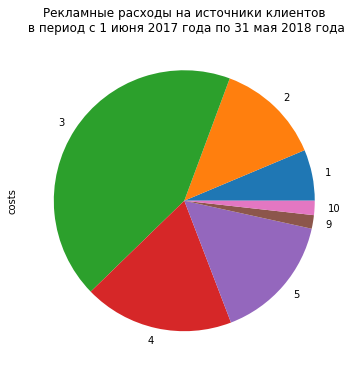

In [28]:
costs.groupby('source_id')['costs'].sum(). \
    plot(kind='pie', figsize=(6, 6))
plt.title("Рекламные расходы на источники клиентов\n в период с 1 июня 2017 года по 31 мая 2018 года")
plt.show()

По итогам знакомства с таблицей costs можно сделать следующие выводы:
- в таблице 2542 записей - столько раз производилась оплата рекламных расходов;
- пропусков в столбцах нет;
- расходы на рекламу были сделаны в период с 1 июня 2017 года по 31 мая 2018 года;
- расходы были сделаны на 7 источников клиентов, среди которых нет источников 6 и 7;
- суммарные расходы составили 329 132 у.е.;
- больше всего расходов было сделано на 3 источник (141 322 у.е.), меньше всего - на 9 и 10 источники (менее 6000 у.е. на каждый).

Необходимо провести следующую предобработку данных:
- столбец dt имеет тип данных object, нужно привести его к типу datetime.

[К началу](#0)

## <a name="5"> Предобработка данных </a>

Приведём названия столбцов в таблицах visits и orders к стилю snake_case:

In [29]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']

Проверим, что названия столбцов обновились:

In [30]:
visits.columns, orders.columns

(Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object'),
 Index(['buy_ts', 'revenue', 'uid'], dtype='object'))

Заменим типы данных в столбцах, которые содержат данные о времени, с типа object на тип datetime:

In [31]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

Проверим, что типы данных обновились:

In [32]:
visits['end_ts'].dtype, \
visits['start_ts'].dtype, \
orders['buy_ts'].dtype, \
costs['dt'].dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'), dtype('<M8[ns]'), dtype('<M8[ns]'))

Тип <M8[ns] - это один из типов datetime64, так что всё хорошо, теперь данные в правильном типе.

В ходе предобработки данных мы:
- привели названия столбцов в таблицах visits и orders к стилю snake_case;
- изменили типы данных в столбцах, которые содержат данные о времени (столбцы end_ts и start_ts таблицы visits, buy_ts таблицы orders и dt таблицы costs), с типа object на тип datetime.

[К началу](#0)

## <a name="6"> Продуктовые метрики </a>

В этом разделе мы будем изучать продуктовые метрики, то есть метрики, связанные с сайтом. Всю достаточную для анализа информацию содержит таблица visits, поэтому будем работать только с ней.

### <a name="7"> Метрики DAU, WAU и MAU </a>

Рассчитаем следующие продуктовые метрики:
- DAU (Daily Active Users) - количество уникальных пользователей, которые посетили сайт, за день;
- WAU (Weekly Active User) - количество уникальных пользователей, которые посетили сайт, за неделю;
- MAU (Monthly Active User) - количество уникальных пользователей, которые посетили сайт, за месяц.

Вычислим средние значения этих метрик за весь период - с 1 июня 2017 по 31 мая 2018 года.

Добавим в таблицу visits три столбца:
- столбец visit_date - дата посещения сайта;
- столбец visit_week - дата первого дня недели, когда было посещение сайта;
- столбец visit_month - дата первого дня месяца, когда было посещение сайта.

In [33]:
visits['visit_date'] = visits['start_ts'].astype('datetime64[D]')
visits['visit_week'] = visits['start_ts'].astype('datetime64[W]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')

Проверим, что столбцы попали в таблицу:

In [34]:
visits.head(1)

,device,end_ts,source_id,start_ts,uid,visit_date,visit_week,visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01


Проверим, что дней, недель и месяцев получилось столько, сколько их действительно в году:

In [35]:
visits['visit_date'].nunique(), visits['visit_week'].nunique(), visits['visit_month'].nunique()

(364, 53, 12)

Число дней составило 364. В 2018 году в феврале было 28 дней, значит в период с 1 июня 2017 по 31 мая 2018 года было 365 дней. То есть в один из дней в этом периоде на сайт никто не заходил. Найдём этот день.

Чтобы его найти, для каждого месяца посчитаем количество дней, когда были посещения сайта. Затем сравним это количество дней с количеством дней в месяцах в принципе. Так найдём месяц, где дней с посещениями меньше, чем дней в месяце.

Добавим столбцы с числом дня и номером месяца:

In [36]:
visits['day_number'] = pd.DatetimeIndex(visits['visit_date']).day
visits['month_number'] = pd.DatetimeIndex(visits['visit_date']).month

Проверим, что столбцы добавились:

In [37]:
visits.head(1)

,device,end_ts,source_id,start_ts,uid,visit_date,visit_week,visit_month,day_number,month_number
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,20,12


Теперь для каждого месяца найдём количество дней, когда были посещения:

In [38]:
for month_number in range(1, 13): # для каждого номера месяца
    # выведем номер месяца и количество дней с посещениями
    print(month_number, 'месяц: дней с посещениями -', 
          visits.query('month_number == @month_number')['day_number'].nunique())

1 месяц: дней с посещениями - 31
2 месяц: дней с посещениями - 28
3 месяц: дней с посещениями - 31
4 месяц: дней с посещениями - 29
5 месяц: дней с посещениями - 31
6 месяц: дней с посещениями - 30
7 месяц: дней с посещениями - 31
8 месяц: дней с посещениями - 31
9 месяц: дней с посещениями - 30
10 месяц: дней с посещениями - 31
11 месяц: дней с посещениями - 30
12 месяц: дней с посещениями - 31


Видно, что в 4 месяц (апрель) дней с посещениями 29, а всего дней в месяце 30. Найдём число апреля, когда не было посещений:

In [39]:
for i in range(1, 31): # для всех чисел в апреле от 1 до 30
    # если числа нет в списке чисел апреля с посещениями
    if i not in visits.query('month_number == 4')['day_number'].unique(): 
        print(i, 'апреля - аномальный день, когда не было посещений сайта.') # вывести это число

1 апреля - аномальный день, когда не было посещений сайта.


1 апреля 2018 года не было посещений. Проверим, что в таблице действительно нет записей с этим числом:

In [40]:
visits[visits['visit_date'] == '2018-04-01']

,device,end_ts,source_id,start_ts,uid,visit_date,visit_week,visit_month,day_number,month_number


Возможно, что 1 апреля был сбой в базе данных и логи не сохранились. Либо в процессе выгрузки таблицы произошёл сбой. В любом случае о проблеме необходимо будет сообщить инженерам.

Теперь удалим добавленные столбцы с числом дня и номером месяца. В будущем они нам больше не понадобятся:

In [41]:
del visits['day_number']
del visits['month_number']

Вернёмся к расчёту продуктовых метрик. 

Чтобы рассчитать cреднее значение DAU за период с 1 июня 2017 по 31 мая 2018 года, сгруппируем данные в таблице visits по дате (столбцу visit_date) и посчитаем для каждой даты число уникальных пользователей. Затем найдём среднее значение количества уникальных пользователей. Это и будет средний DAU за год, то есть среднее количество уникальных пользователей, которые посетили сайт.

In [42]:
int(visits.groupby('visit_date')['uid'].nunique().mean())

907

Чтобы рассчитать WAU, нужно сделать всё то же самое, только группировку сделать по столбцу visit_week (то есть по первому дню недели, когда были посещения):

In [43]:
int(visits.groupby('visit_week')['uid'].nunique().mean())

5724

Для расчёта MAU группировку делаем по столбцу visit_month (то есть по первому дню месяца, когда были посещения):

In [44]:
int(visits.groupby('visit_month')['uid'].nunique().mean())

23228

У нас получилось, что за период с 1 июня 2017 по 31 мая 2018 года:
- среднее значение DAU составляет 907;
- среднее значение WAU составляет 5724;
- среднее значение MAU составляет 23 228.

Теперь посмотрим, как менялись эти метрики во времени. Для наглядности будет строить графики. 

Если строить график по ежедневному значению DAU, то график получится зашумленным - у нас будет 364 столбца. Поэтому для каждого месяца рассчитаем среднее значение DAU, а затем построим график ежемесячного изменения этой метрики.

Построим таблицу с месяцами и средним значением DAU для этих месяцев. Для этого сгруппируем таблицу visits по столбцу visit_month и visit_date и найдём число уникальных пользователей. Затем сгруппируем по столбцу visit_month и найдём среднее значение уникальных пользователей в день:

In [45]:
average_dau = visits.groupby(['visit_month', 'visit_date'])['uid'].nunique() \
                .reset_index().groupby('visit_month')['uid'].mean()
average_dau

visit_month
2017-06-01     510.666667
2017-07-01     532.064516
2017-08-01     433.258065
2017-09-01     739.066667
2017-10-01    1133.354839
2017-11-01    1328.966667
2017-12-01    1240.967742
2018-01-01    1096.838710
2018-02-01    1217.142857
2018-03-01    1052.677419
2018-04-01     845.655172
2018-05-01     786.451613
Name: uid, dtype: float64

Теперь построим график, на котором будет видно, как средний DAU менялся от месяца к месяцу.

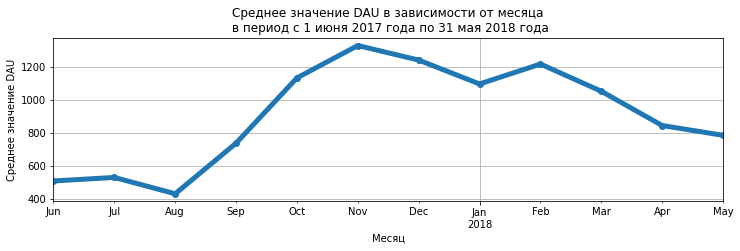

In [46]:
average_dau.plot(style='o-', linewidth=5, figsize=(12,3), grid=True)
plt.title("Среднее значение DAU в зависимости от месяца\n в период с 1 июня 2017 года по 31 мая 2018 года")
plt.xlabel("Месяц")
plt.ylabel("Среднее значение DAU")
plt.show()

Значения WAU также усредним по месяцам и построим график:

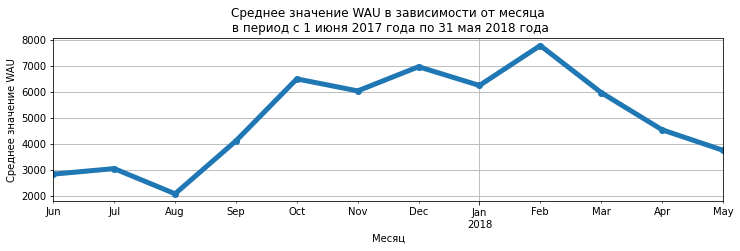

In [47]:
average_wau = visits.groupby(['visit_month', 'visit_week'])['uid'].nunique(). \
                reset_index().groupby('visit_month')['uid'].mean()
average_wau.plot(style='o-', linewidth=5, figsize=(12,3), grid=True)
plt.title("Среднее значение WAU в зависимости от месяца\n в период с 1 июня 2017 года по 31 мая 2018 года")
plt.xlabel("Месяц")
plt.ylabel("Среднее значение WAU")
plt.show()

Значения MAU усреднять по месяцам не нужно (они по определению усреднены). Построим график:

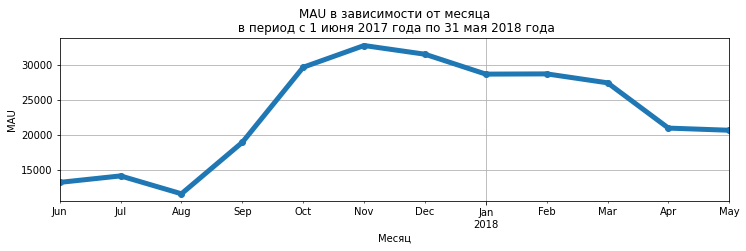

In [48]:
visits.groupby('visit_month')['uid'].nunique(). \
    plot(style='o-', linewidth=5, figsize=(12,3), grid=True)
plt.title("MAU в зависимости от месяца\n в период с 1 июня 2017 года по 31 мая 2018 года")
plt.xlabel("Месяц")
plt.ylabel("MAU")
plt.show()

В течение года:
- среднее значение DAU менялось от 400 в неудачный август до 1400 в удачный ноябрь;
- среднее значение WAU менялось от 2000 в неудачный август до 8000 в удачный февраль;
- среднее значение MAU менялось от 11 000 в неудачный август до 33 000 в удачный ноябрь;
- зимой и осенью пользователи активизировались - количество посетителей сайта более, чем удваивалось по всем метрикам.

То, что наибольшие DAU и WAU наблюдаются в разные месяцы - это нормально. Например, наибольший WAU в феврале означает, что приходило много уникальных посетителей в среднем за неделю, но они могли приходить, например, лишь по разу на сайт. А наибольший DAU в ноябре означает, что приходило много уникальных посетителей в среднем за день, но в течение недели это могли быть во многом те же посетители. Поэтому WAU для ноября оказался не таким высоким.

### <a name="8"> Среднее количество посещений сайта пользователем в сутки </a>

Рассчитаем, сколько раз пользователи в среднем заходят на сайт в сутки. У нас уже есть посчитанная метрика DAU, то есть количество пользователей, которые зашли на сайт в сутки. Теперь найдём количество посещений сайта в сутки, и поделим его на DAU. Так мы и узнаем, сколько раз пользователи в среднем посещают сайт в сутки.

Таблица со средними DAU по месяцам уже посчитана - её хранит переменная average_dau. Составим таблицу со средним количеством посещений в сутки для каждого месяца, рассчитаем её:

In [49]:
average_daily_visits = visits.groupby(['visit_month', 'visit_date'])['uid'].count() \
                        .reset_index().groupby('visit_month')['uid'].mean()
average_daily_visits

visit_month
2017-06-01     550.166667
2017-07-01     575.096774
2017-08-01     463.064516
2017-09-01     796.900000
2017-10-01    1222.677419
2017-11-01    1465.633333
2017-12-01    1354.290323
2018-01-01    1191.580645
2018-02-01    1327.928571
2018-03-01    1150.935484
2018-04-01     914.310345
2018-05-01     859.193548
Name: uid, dtype: float64

Теперь найдём среднее количество посещений одним пользователем в сутки. Поделим посещения на пользователей:

In [50]:
average_daily_visits_per_visitor = average_daily_visits / average_dau
average_daily_visits_per_visitor.mean()

1.085221837412899

Построим график, как меняется среднее количество посещений сайта пользователем в сутки в зависимости от месяца:

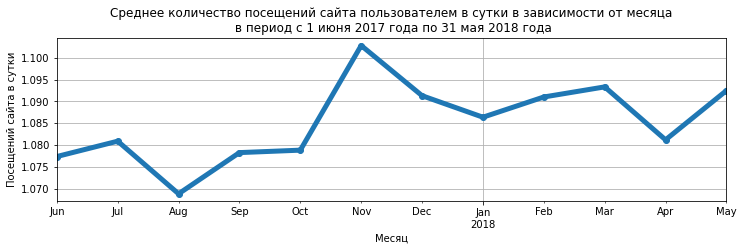

In [51]:
average_daily_visits_per_visitor.plot(style='o-', linewidth=5, figsize=(12,3), grid=True)
plt.title("Среднее количество посещений сайта пользователем в сутки в зависимости от месяца\n в период с \
1 июня 2017 года по 31 мая 2018 года")
plt.xlabel("Месяц")
plt.ylabel("Посещений сайта в сутки")
plt.show()

Наблюдения:
- среднее количество посещений сайта пользователем в сутки наименьшее в августе - 1,07 раза. Наибольшее - в ноябре - 1,10;
- в динамике наблюдается сезонность - осенью и зимой пользователи делают больше заходов на сайт.

### <a name="9"> Продолжительность пользовательской сессии (ASL) </a>

Рассчитаем среднюю продолжительность пользовательской сессии (ASL, average session length) за весь период времени. Для этого добавим в таблицу visits новый столбец с длинной сессии, измеренной в секундах:

In [52]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

Проверим, что столбец добавлен и рассчитан верно:

In [53]:
visits.head(1)

,device,end_ts,source_id,start_ts,uid,visit_date,visit_week,visit_month,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080


Видно, что первая сессия длилась 18 минут: началась в 17:20 и закончилась в 17:38. Пересчитаем в секунды и проверим значение в столбце session_duration_sec:

In [54]:
18 * 60

1080

Всё верно.

Теперь оценим набор значений продолжительности сессий с точки зрения статистических параметров:

In [55]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

Средняя продолжительность сессии (ASL) составляет 643 секунды, медианная - 300 секунд. Видно, что максимальное значение на два порядка больше 3 квартиля. Оно и другие выбросы и утягивают среднее значение вверх по сравнению с медианным. Построим ящик с усами, чтобы оценить, где в диапазоне всех значений лежит сам ящик (2 и 3 квартили):

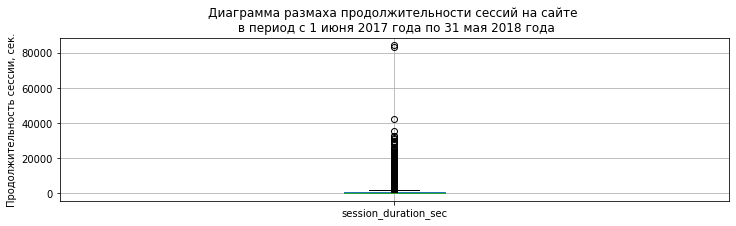

In [56]:
visits.boxplot('session_duration_sec', figsize=(12,3))
plt.title("Диаграмма размаха продолжительности сессий на сайте \n в период с 1 июня 2017 года по 31 мая 2018 года")
plt.ylabel("Продолжительность сессии, сек.")
plt.show()

Как и ожидалось, ящик сплюснут из-за сильно выбивающихся выбросов. Найдём верхнюю границу для нормальных значений, выше которой уже будут выбросы. Для поиска этой границы обычно применяют один из двух методов:
- к 3 квартилю прибавляют 1,5 межквартильных размаха;
- находят 95 процентиль.

Воспользуемся вторым способом - он чуть проще в расчёте:

In [57]:
percentile_95 = np.percentile(visits['session_duration_sec'], 95)
percentile_95

2280.0

Теперь построим гистограмму распределения продолжительности сессий. Диапазон отображения ограничим 95 процентилем, чтобы исключить выбросы. 

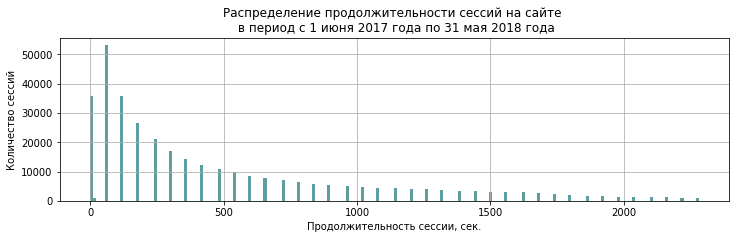

In [58]:
visits['session_duration_sec'].hist(bins=200, range=(0, percentile_95), figsize=(12,3), color='cadetblue')
plt.title("Распределение продолжительности сессий на сайте \n в период с 1 июня 2017 года по 31 мая 2018 года")
plt.xlabel("Продолжительность сессии, сек.")
plt.ylabel("Количество сессий")
plt.show()

Время - это непрерывная величина, а наша гистограмма получилась такой, будто продолжительность сессии - это дискретная величина. То есть в диапазоне 2280 секунд (от 0 до 95 процентиля) мы видим всего несколько столбцов, причем расположенных с равным интервалом. Посмотрим поближе, изучим диапазон 0-300 секунд:

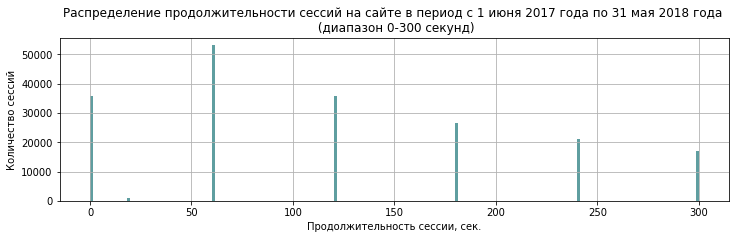

In [59]:
visits['session_duration_sec'].hist(bins=200, range=(0, 300), figsize=(12,3), color='cadetblue')
plt.title("Распределение продолжительности сессий на сайте в период с 1 июня 2017 года по 31 мая 2018 года \n (диапазон \
0-300 секунд)")
plt.xlabel("Продолжительность сессии, сек.")
plt.ylabel("Количество сессий")
plt.show()

In [60]:
visits.query('session_duration_sec <= 300')['session_duration_sec'].unique()

array([  0,  60, 180, 240, 300, 120,  19])

В диапазоне 0-300 секунд есть всего 7 столбцов. То есть посетители проводили на сайте 0, 19 секунд, 1, 2, 3, 4 или 5 минут. Видимо время сессии фиксируется минутами и еще есть метка в 19 секунд. Такая метка выглядит странно, посчитаем количество посещений такой продолжительностью:

In [61]:
len(visits.query('session_duration_sec == 19'))

868

Значение встречается неединично. Нужно уточнить у инженеров, чем вызвано наличие такой метки.

Так как время сессии в основном измеряется минутами, то мы можем просто уменьшить количество корзин в изначальной гистограмме и получим гистограмму без прерываний. При этом будем держать в голове, что продолжительность распределяется по минутам (+ метка в 19 секунд), а не секундам:

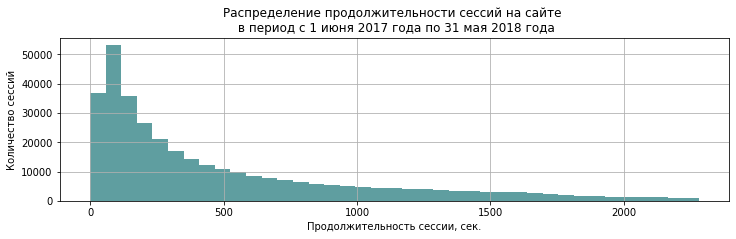

In [62]:
bins_need = visits.query('session_duration_sec < @percentile_95')['session_duration_sec'].nunique()
visits['session_duration_sec'].hist(bins=bins_need, range=(0, percentile_95), figsize=(12,3), color='cadetblue')
plt.title("Распределение продолжительности сессий на сайте \n в период с 1 июня 2017 года по 31 мая 2018 года")
plt.xlabel("Продолжительность сессии, сек.")
plt.ylabel("Количество сессий")
plt.show()

Распределение похоже на распределение Пуассона. Среднее и медианное значения мы уже нашли, они составили 643 и 300 секунд. Найдём самое популярное значение - моду:

In [63]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

Получилось, что средняя продолжительность сессии (ASL) составила 643 секудны или почти 11 минут, но чаще всего посетители проводят на сайте 1 минуту.

### <a name="10"> Когортный анализ и Retention Rate </a>

Проведём когортный анализ посетителей. Будем изучать, как влияет месяц, когда пользователь впервые посетил сайт, на его дальнейшие посещения в следующие месяцы. То есть в нашем случае когортами будут группы пользователей, которых объединяет месяц первого посещения сайта.

Создадим таблицу first_visits, в которой сохраним для каждого пользователя месяц его первого посещения сайта:

In [64]:
first_visit_months = visits.groupby('uid')[['visit_month']].min().reset_index()
first_visit_months = first_visit_months.rename(columns={'visit_month': 'first_visit_month'})
first_visit_months.head(3)

,uid,first_visit_month
0,11863502262781,2018-03-01
1,49537067089222,2018-02-01
2,297729379853735,2017-06-01


Теперь добавим в таблицу visits новый столбец, в котором будет дата первого посещения сайта для пользователя. Объединим таблицы visits и first_visit_months по uid:

In [65]:
visits = pd.merge(visits, first_visit_months, on='uid')
visits.head(3)

,device,end_ts,source_id,start_ts,uid,visit_date,visit_week,visit_month,session_duration_sec,first_visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01


Теперь добавим столбец lifetime, в котором будем хранить для каждого посещения число прошедших месяцев с первого посещения для этого пользователя. Для этого найдём разницу между месяцем посещения и первым месяцем посещения. Разница будет посчитана в количестве дней. Чтобы перевести её в месяцы, поделим на константу timedelta64(1,'M'), которая представляет собой среднюю длину месяца в году:

In [66]:
visits['lifetime'] = ((visits['visit_month'] - visits['first_visit_month']) \
                      / np.timedelta64(1,'M')).round().astype('int')

Теперь сгруппируем таблицу по когортам (столбцу first_visit_month) и посчитаем для каждого номера месяца из столбца lifetime количество уникальных посетителей на сайте:

In [67]:
users_by_cohorts = visits.pivot_table(index='first_visit_month', columns='lifetime', values='uid', aggfunc='nunique')
users_by_cohorts.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,13259.0,1043,713,814,909,947,809,766,694,674,539,596
2017-07-01,13140.0,737,674,738,765,633,596,601,510,376,361,
2017-08-01,10181.0,783,640,639,510,448,370,402,284,265,,
2017-09-01,16704.0,1428,1156,847,658,632,599,404,381,,,
2017-10-01,25977.0,2042,1357,1012,890,837,555,529,,,,
2017-11-01,27248.0,2133,1202,1054,919,638,594,,,,,
2017-12-01,25268.0,1410,960,786,512,481,,,,,,
2018-01-01,22624.0,1351,890,565,458,,,,,,,
2018-02-01,22197.0,1267,565,446,,,,,,,,


Проверим, что группировка сделана правильно. Выведем значение посетителей для первой когорты в 1 месяц lifetime:

In [68]:
visits.query('first_visit_month == "2017-06-01" and visit_month == "2017-07-01"')['uid'].nunique()

1043

Всё верно.

Построим тепловую карту для наглядности:

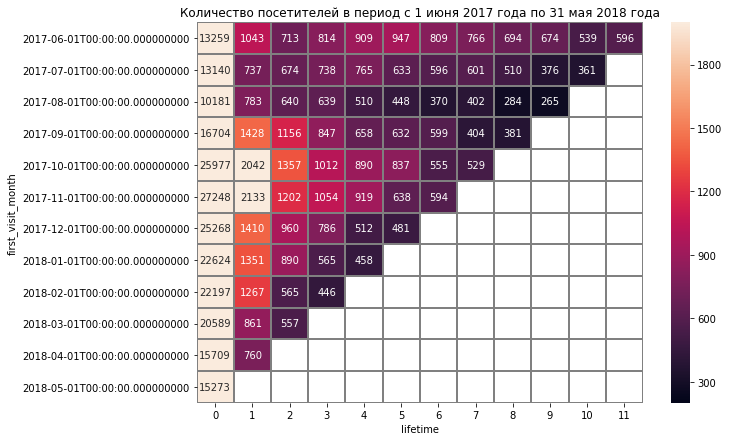

In [69]:
plt.figure(figsize=(10, 7))
plt.title("Количество посетителей в период с 1 июня 2017 года по 31 мая 2018 года")
sns.heatmap(users_by_cohorts, annot=True, fmt='.0f', linewidths=1, linecolor='gray', vmin=200, vmax=2000)
plt.show()

По тепловой карте можно сделать следующие выводы:
- в когортах октября, ноября, декабря почти в два раза больше пользователей, чем в когортах июня, июля, апреля, мая. Например, в ноябре сайт посетило 27 248 новых пользователей, а в мае - 15 273. Это говорит о том, что в конце осени и начале зимы прирост новых посетителей был особенно сильным. Похоже на сезонность;
- в августе был сильный спад - сайт посетило всего 10 181 новых пользователей;
- начиная с 1 месяца lifetime количество пользователей, которые продолжают посещать сайт, сильно падает по всем когортам. Так как цвета отражают абсолютные значения в ячейках, то сложно оценить какая когорта со временем ведёт себя лучше или хуже. Чтобы решить эту проблему, потребуется построить тепловую карту с Retention Rate. Сделаем это чуть позже.

Построим график, на котором отобразим, как менялось количество новых пользователей на сайте от месяца к месяцу. Фактически это будет графическая визуализация столбца 0 месяца lifetime из тепловой карты.

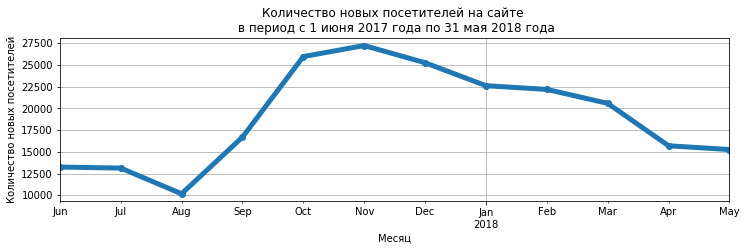

In [70]:
first_visit_months.groupby('first_visit_month')['uid'].nunique() \
    .plot(style='o-', linewidth=5, figsize=(12,3), grid=True)
plt.title("Количество новых посетителей на сайте \n в период с 1 июня 2017 года по 31 мая 2018 года")
plt.xlabel("Месяц")
plt.ylabel("Количество новых посетителей")
plt.show()

Теперь посчитаем для каждой когорты и месяца lifetime значение Retention Rate. Напомним, что Retention Rate - это метрика, которая показывает, сколько пользователей продолжает посещать сайт через определённый период времени, и рассчитывается как количество пользователей в опеределённый месяц lifetime, делённое на количество пользователей в нулевой месяц lifetime.

Составим перечень всех месяцев lifetime и сохраним в их списке lifetimes:

In [71]:
lifetimes = list(users_by_cohorts.columns)
lifetimes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Теперь поделим количество пользователей в каждый месяц lifetime на количество пользователей в нулевой месяц lifetime:

In [72]:
lifetimes.reverse() # развернём список, чтобы в цикле первый столбец был поделён сам на себя последним
for lifetime in lifetimes: # для каждого месяца lifetime
    users_by_cohorts[lifetime] = users_by_cohorts[lifetime] / users_by_cohorts[0] # найдём Retention Rate
users_by_cohorts.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.0786635,0.0537748,0.0613923,0.0685572,0.0714232,0.0610152,0.0577721,0.0523418,0.0508334,0.0406516,0.0449506
2017-07-01,1.0,0.0560883,0.0512938,0.0561644,0.0582192,0.0481735,0.0453577,0.0457382,0.0388128,0.0286149,0.0274734,
2017-08-01,1.0,0.076908,0.0628622,0.062764,0.0500933,0.0440035,0.0363422,0.0394853,0.0278951,0.0260289,,
2017-09-01,1.0,0.0854885,0.069205,0.0507064,0.0393918,0.0378352,0.0358597,0.0241858,0.0228089,,,
2017-10-01,1.0,0.078608,0.0522385,0.0389575,0.0342611,0.0322208,0.0213651,0.0203642,,,,
2017-11-01,1.0,0.078281,0.0441133,0.0386817,0.0337272,0.0234146,0.0217998,,,,,
2017-12-01,1.0,0.0558018,0.0379927,0.0311065,0.0202628,0.0190359,,,,,,
2018-01-01,1.0,0.0597153,0.0393388,0.0249735,0.020244,,,,,,,
2018-02-01,1.0,0.0570798,0.0254539,0.0200928,,,,,,,,


Построим тепловую карту:

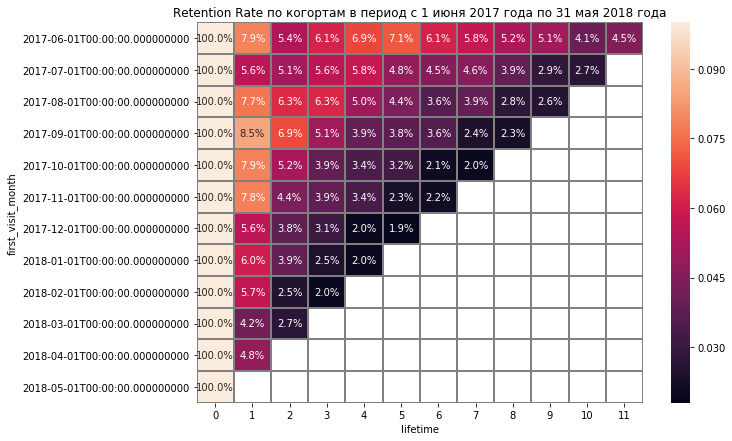

In [73]:
plt.figure(figsize=(10, 7))
plt.title("Retention Rate по когортам в период с 1 июня 2017 года по 31 мая 2018 года")
sns.heatmap(users_by_cohorts, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=.018, vmax=.1)
plt.show()

На карте видно, что:
- Retention Rate в 1 месяц lifetime колеблется от 4,2% для мартовской когорты до 8,5% для сентябрьской когорты. На сайт возвращается меньше 10% пользователей в последующие месяцы. То есть подавляющее большинство уходит и не возвращается;
- лучше всего пользователи удерживаются в июньской когорте - в отличие от других когорт здесь Retention Rate ни разу не опускался ниже 4%;
- в целом летние когорты показывают лучший Retention Rate с течением времени по сравнению с другими когортами;
- январьская когорта показала самый низкий Retention Rate - 1,9% в 5 месяц lifetime.

Посчитаем усредненный по когортам Retention Rate:

In [74]:
pd.DataFrame(users_by_cohorts.mean(axis=0).round(3)).T * 100 # умножим на 100, чтобы было удобнее сравнивать c % 

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
0,100.0,6.5,4.6,4.3,4.1,3.9,3.7,3.8,3.5,3.5,3.4,4.5


### <a name="11"> Выводы по продуктовым метрикам  </a>

На основе изучения продуктовых метрик сайта можно сделать следующие выводы:
- среднее значение DAU составляет 907, WAU - 5724, MAU - 23 228. Эти метрики связаны с сезонностью: зимой и осенью количество уникальных посетителей сайта возрастает более, чем в два раза по сравнению с летом и весной;
- среднее количество посещений сайта пользователем в сутки - 1,09 раз. В этой метрике также наблюдается сезонность: осенью и зимой пользователи делают больше заходов на сайт;
- средняя продолжительность сессии на сайте (ASL) составляет почти 11 минут, медианная - 5 минут. Но чаще всего посетители проводят на сайте 1 минуту;
- в октябре, ноябре и декабре на сайт пришло почти в два раза больше посетителей, чем в июне, июле, апреле, мае. Например, в ноябре сайт посетило 27 248 новых пользователей, а в мае - 15 273. Также наблюдается сезонность;
- Retention Rate со 100% в нулевой месяц жизни падает сразу до 6,5% в первый месяц жизни и далее в течение года плавно снижается ближе к 4%. Для метрики сезонность также есть, но работает в обратную сторону: посетители пришедшие летом в среднем чаще возвращаются на сайт, чем посетители, пришедшие осенью и зимой.

Были найдены аномалии:
- нет данных о посещениях за 1 апреля. Об этом нужно уведомить инженеров, чтобы выснить, является ли это ошибкой или в этот день, например, не работал сайт;
- продолжительность сессии измеряется в минутах, однако 868 раз встречается метка в 19 секунд. Надо уточнить - норма это или баг.

[К началу](#0)

## <a name="12"> Метрики электронной коммерции </a>

В этом разделе мы будем изучать метрики электронной коммерции, то есть метрики, связанные с заказами. Всю достаточную для анализа информацию помимо таблицы visits содержит таблица orders, поэтому будем работать только с ними двумя.

### <a name="13"> Среднее время на покупку  </a>

Найдём среднее время, которое потребовалось пользователям, чтобы совершить первый заказ. Для этого нужно найти разницу между датой и временем первого заказа и первого посещения сайта.

В таблице orders хранятся записи о заказах пользователей. Проверим, есть ли там пользователи, которые совершали заказ более одного раза, или все пользователи совершали только один заказ. Сравним количество записей о заказах с количеством уникальных пользователей в таблице:

In [75]:
if orders.uid.nunique() < len(orders):
    print('В таблице есть пользователи, которые совершили более одного заказа.')
else:
    print('В таблице все пользователи совершили только один заказ.')

В таблице есть пользователи, которые совершили более одного заказа.


Это значит, что нам нужно для каждого пользователя найти дату его первой покупки:

In [76]:
first_orders = orders.groupby('uid')[['buy_ts']].min().reset_index()
first_orders.columns = ['uid', 'first_order']
first_orders.head(3)

,uid,first_order
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00


Ранее для когортного анализа Retention Rate мы находили первый день месяца, когда посетитель впервые зашёл на сайт. Теперь нам нужна дата и время, когда посетитель впервые зашёл на сайт, с точностью до секунды. Составим таблицу с пользователями и их первыми посещениями сайта:

In [77]:
first_visits = visits.groupby('uid')[['start_ts']].min().reset_index()
first_visits = first_visits.merge(visits, on=['uid', 'start_ts'])[['uid', 'start_ts', 'device']]
first_visits = first_visits.rename(columns={'start_ts': 'first_visit'})
first_visits.head(3)

,uid,first_visit,device
0,11863502262781,2018-03-01 17:27:00,touch
1,49537067089222,2018-02-06 15:55:00,touch
2,297729379853735,2017-06-07 18:47:00,desktop


Для каждого пользователя мы сделали столбец с его типом устройства. Это позволит нам анализировать среднее время на покупку в зависимости от устройства.

Объединим таблицы с первыми заказами и первыми посещениями по столбцу uid:

In [78]:
visits_to_orders = pd.merge(first_visits, first_orders, on='uid')
visits_to_orders.head(3)

,uid,first_visit,device,first_order
0,313578113262317,2017-09-18 22:49:00,desktop,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,touch,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,desktop,2017-10-11 18:33:00


In [79]:
print(len(visits_to_orders))

36523


В таблице 36 523 строки - столько же, сколько и уникальных покупателей (это значение хранит переменная total_buyers). Значит соединение таблиц сделали правильно, остались только клиенты с заказами.

Теперь добавим столбец с разницей во времени между первым заказом и первым посещением сайта:

In [80]:
# столбец с разницей в днях, часах, минутах, секундах:
visits_to_orders['visit_to_order_dur'] = visits_to_orders['first_order'] - visits_to_orders['first_visit']
# столбец с разницей в минутах:
visits_to_orders['visit_to_order_dur_min'] = (visits_to_orders['visit_to_order_dur'] / np.timedelta64(1,'m')) \
    .round().astype('int')
visits_to_orders.head(3)

,uid,first_visit,device,first_order,visit_to_order_dur,visit_to_order_dur_min
0,313578113262317,2017-09-18 22:49:00,desktop,2018-01-03 21:51:00,106 days 23:02:00,154022
1,1575281904278712,2017-06-03 10:13:00,touch,2017-06-03 10:13:00,0 days 00:00:00,0
2,2429014661409475,2017-10-11 17:14:00,desktop,2017-10-11 18:33:00,0 days 01:19:00,79


Оценим разницу во времени между посещением и заказом с точки зрения статистических параметров. Оценивать будем отдельно для компьютеров и смартфонов:

In [81]:
visits_to_orders.query('device == "desktop"')['visit_to_order_dur'].describe()

count                      29211
mean     16 days 00:15:26.040875
std      46 days 03:56:23.471031
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:15:00
75%              1 days 03:09:30
max            363 days 07:04:00
Name: visit_to_order_dur, dtype: object

In [82]:
visits_to_orders.query('device == "desktop"')['visit_to_order_dur_min'].mode()

0    1
dtype: int64

In [83]:
visits_to_orders.query('device == "touch"')['visit_to_order_dur'].describe()

count                       7312
mean     20 days 11:12:38.525711
std      50 days 09:15:32.650232
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:38:00
75%              6 days 23:11:15
max            362 days 16:47:00
Name: visit_to_order_dur, dtype: object

In [84]:
visits_to_orders.query('device == "touch"')['visit_to_order_dur_min'].mode()

0    0
dtype: int64

Среднее время на заказ для компьютеров - 16 дней, для смартфонов - 20 дней. Медианное время для компьютеров - 15 минут, для смартфонов - 38 минут. Наиболее часто встречающееся время на заказ для компьютеров - 1 минута, для смартфонов - менее минуты.

Выбросы сильно утягивают вверх среднее значение. Построим ящикм с усами для компьютеров и смартфонов, чтобы оценить, где в диапазоне всех значений лежат сами ящики:

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


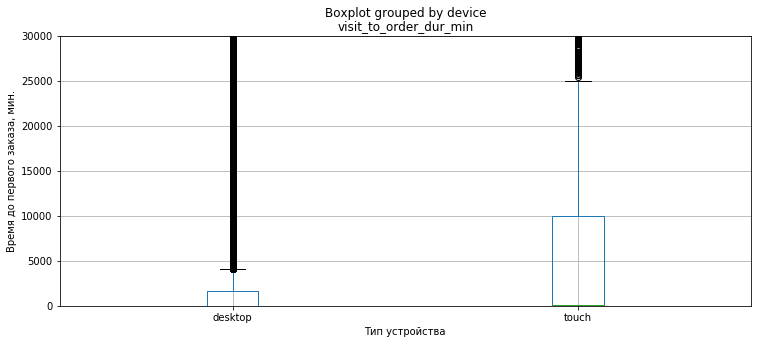

In [85]:
# боксплот строим по столбцу с разницей по времени, измеренной в минутах
visits_to_orders.boxplot('visit_to_order_dur_min', by='device', figsize=(12,5))
plt.xlabel("Тип устройства")
plt.ylabel("Время до первого заказа, мин.")
plt.ylim(0, 30000)
plt.show()

Ящик у смартфонов намного шире, чем у компьютеров. Пользователи смартфонов дольше принимают решение о покупке. 

Оценим совместные данные:

In [86]:
visits_to_orders['visit_to_order_dur'].describe()

count                      36523
mean     16 days 21:40:10.550064
std      47 days 01:44:46.481416
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:00
max            363 days 07:04:00
Name: visit_to_order_dur, dtype: object

In [87]:
visits_to_orders['visit_to_order_dur_min'].mode()

0    1
dtype: int64

Среднее необходимое время на заказ - 16 дней 21 час и 40 минут, медианное время - 16 минут, мода - 1 минута. 


Построим гистограмму, чтобы визуально оценить распределение времени на заказ. Для границы графика используем верхнюю границу для нормальных значений, выше которой уже будут выбросы. На этот раз используем метод, когда к 3 квартилю прибавляют 1,5 межквартильных размаха:

In [88]:
upper_whisker = np.percentile(visits_to_orders['visit_to_order_dur_min'], 75) + \
                   1.5 * (np.percentile(visits_to_orders['visit_to_order_dur_min'], 75) - 
                   np.percentile(visits_to_orders['visit_to_order_dur_min'], 25))
upper_whisker

7236.5

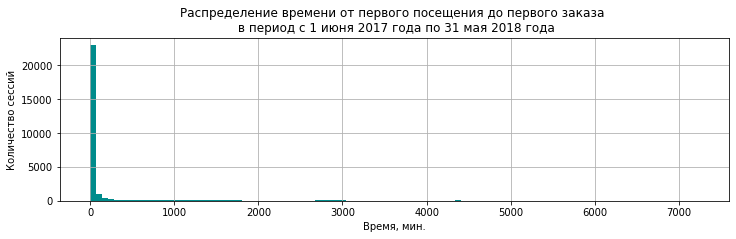

In [89]:
visits_to_orders.hist('visit_to_order_dur_min', bins=100, range=(0, upper_whisker), 
                      figsize=(12,3), color='darkcyan')
plt.title("Распределение времени от первого посещения до первого заказа \n в период с 1 июня 2017 года по 31 мая 2018 года")
plt.xlabel("Время, мин.")
plt.ylabel("Количество сессий")
plt.show()

Даже с ограничением графика от выбросов сверху он всё равно сжимается вблизи нулевой отметки. Подберём границу вручную, чтобы можно было лучше увидеть распределение:

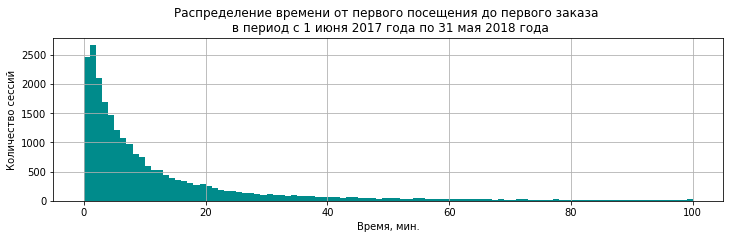

In [90]:
visits_to_orders.hist('visit_to_order_dur_min', bins=100, range=(0, 100), figsize=(12,3), color='darkcyan')
plt.title("Распределение времени от первого посещения до первого заказа \n в период с 1 июня 2017 года по 31 мая 2018 года")
plt.xlabel("Время, мин.")
plt.ylabel("Количество сессий")
plt.show()

Так гораздо лучше. Распределение похоже на распределение Пуассона. 

По итогам анализа времени на заказ получилось, что:
- пользователи смартфонов дольше принимают решение о покупке: медианное время 38 минут против 15;
- со смартфонов наиболее часто покупают меньше, чем за минуту, а с компьютеров - чуть больше, чем за минуту;
- среднее необходимое время на заказ независимо от типа устройств - почти 17 дней, медианное время - 16 минут.


### <a name="14"> Среднее количество покупок </a>

Посчитаем, сколько в среднем покупок за 6 месяцев совершает клиент. Под клиентом будем считать такого пользователя, который совершил хотя бы одну покупку. Среднее количество покупок будем считать для разных когорт, а клиентов делить на когорты будем по месяцу первой покупки.

Для начала добавим в таблицу orders столбец с датой первого заказа для каждого клиента. Информация с датой первого заказа у нас уже есть, она хранится в таблице visits_to_orders:

In [91]:
visits_to_orders.head(3)

,uid,first_visit,device,first_order,visit_to_order_dur,visit_to_order_dur_min
0,313578113262317,2017-09-18 22:49:00,desktop,2018-01-03 21:51:00,106 days 23:02:00,154022
1,1575281904278712,2017-06-03 10:13:00,touch,2017-06-03 10:13:00,0 days 00:00:00,0
2,2429014661409475,2017-10-11 17:14:00,desktop,2017-10-11 18:33:00,0 days 01:19:00,79


Добавим столбец first_order в таблицу orders путём объединения таблиц orders и first_orders по столбцу uid:

In [92]:
orders = pd.merge(orders, visits_to_orders[['uid', 'device', 'first_order']], on='uid')
orders.head(3)

,buy_ts,revenue,uid,device,first_order
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:27:00


Чтобы выделить когорты (месяц первой покупки), добавим столбец first_order_month, в котором будет храниться первый день месяца первой покупки. Также добавим столбец order_month с первым днём месяца каждой покупки:

In [93]:
orders['first_order_month'] = orders['first_order'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head(3)

,buy_ts,revenue,uid,device,first_order,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:27:00,2017-06-01,2017-06-01


При знакомстве с данными в таблице orders мы заметили, что записи датированы от 1 июня 2017 до 1 июня 2018 года, хотя таблица с посещениями сайта visits и оплатой рекламы costs содержат данные только от 1 июня 2017 до 31 мая 2018 года. Найдём вылезающее из годового периода значение в таблице orders:

In [94]:
orders.query('order_month == "2018-06-01"')

,buy_ts,revenue,uid,device,first_order,first_order_month,order_month
50414,2018-06-01 00:02:00,3.42,83872787173869366,desktop,2018-06-01 00:02:00,2018-06-01,2018-06-01


Есть всего одна такая покупка, которая произошла в 00:02:00, то есть вылезла на две минуты. Проверим, есть ли у данного покупателя еще покупки помимо этой: 

In [95]:
orders.query('uid == 83872787173869366')

,buy_ts,revenue,uid,device,first_order,first_order_month,order_month
50414,2018-06-01 00:02:00,3.42,83872787173869366,desktop,2018-06-01 00:02:00,2018-06-01,2018-06-01


Нет, только одна покупка. Чтобы не создавать для этого клиента отдельную когорту, исключим запись из таблицы:

In [96]:
orders = orders.drop(50414)
orders.query('uid == 83872787173869366')

,buy_ts,revenue,uid,device,first_order,first_order_month,order_month


Запись удалена.

Теперь создадим столбец lifetime, в котором будем хранить для каждого заказа число прошедших месяцев с первого заказа для этого пользователя:

In [97]:
orders['lifetime'] = ((orders['order_month'] - orders['first_order_month']) / np.timedelta64(1,'M')) \
                        .round().astype('int')
orders.head(3)

,buy_ts,revenue,uid,device,first_order,first_order_month,order_month,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:27:00,2017-06-01,2017-06-01,0


Сгруппируем таблицу по когортам и посчитаем для каждого месяца lifetime количество покупок. Причём сделаем это накопительным итогом, чтобы видеть, как от месяца к месяцу растёт объём заказов:

In [98]:
orders_by_cohorts = orders.pivot_table(index='first_order_month', columns='lifetime', 
                                       values='uid', aggfunc='count')
cum_orders_by_cohorts = orders_by_cohorts.cumsum(axis=1)
cum_orders_by_cohorts.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,2354.0,2531,2705,2931,3223,3441,3717,3891,4103,4256,4352,4438
2017-07-01,2186.0,2286,2406,2510,2582,2664,2725,2775,2833,2857,2910,
2017-08-01,1533.0,1641,1741,1822,1907,1969,2018,2096,2142,2188,,
2017-09-01,2933.0,3152,3313,3477,3544,3653,3761,3817,3878,,,
2017-10-01,4964.0,5278,5440,5562,5691,5794,5880,6005,,,,
2017-11-01,4813.0,5210,5392,5603,5739,5798,5900,,,,,
2017-12-01,5052.0,5322,5524,5703,5789,5894,,,,,,
2018-01-01,3783.0,4007,4166,4230,4308,,,,,,,
2018-02-01,4095.0,4317,4400,4470,,,,,,,,


Так как нам нужно найти среднее количество покупок на одного пользователя за 6 месяцев, то мы можем анализировать только те когорты, которые имеют данные за минимум 6 месяцев, то есть за минимум 0-5 месяцы lifetime. Все неподходящие когорты, то есть когорты с клиентами, которые совершили первый заказ после 1 января 2018 года, удалим из таблицы. 

Для оставшихся когорт нам не подойдут данные за 6-11 месяцы lifetime. Это связано с тем, что чем больше месяцев lifetime мы берём в расчёт, тем ниже будет среднее количество покупок на клиента за 6 месяцев. Сказывается ослабевающее влияние большого количества покупок в 0 месяц lifetime. Чтобы исключить такое искажение, будем оценивать число покупок только в первые 6 месяцев, то есть 0-5 месяцы lifetime. Обрежем таблицу:

In [99]:
cum_orders_by_cohorts = cum_orders_by_cohorts.iloc[:7,:6]
cum_orders_by_cohorts

lifetime,0,1,2,3,4,5
first_order_month,,,,,,
2017-06-01,2354.0,2531.0,2705.0,2931.0,3223.0,3441.0
2017-07-01,2186.0,2286.0,2406.0,2510.0,2582.0,2664.0
2017-08-01,1533.0,1641.0,1741.0,1822.0,1907.0,1969.0
2017-09-01,2933.0,3152.0,3313.0,3477.0,3544.0,3653.0
2017-10-01,4964.0,5278.0,5440.0,5562.0,5691.0,5794.0
2017-11-01,4813.0,5210.0,5392.0,5603.0,5739.0,5798.0
2017-12-01,5052.0,5322.0,5524.0,5703.0,5789.0,5894.0


Теперь нам нужно поделить количество заказов в каждой ячейке на количество покупателей в данной когорте. Для этого сначала найдём число покупателей в когортах:

In [100]:
buyers_by_cohorts = orders.groupby('first_order_month')[['uid']].nunique()
buyers_by_cohorts.iloc[:7].T

first_order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01
uid,2023,1923,1370,2581,4340,4081,4383


Давайте сразу построим диаграмму, на которой можно будет сравнить для каждой когорты, как соотносятся количество покупателей с количеством заказов за первые 6 месяцев:

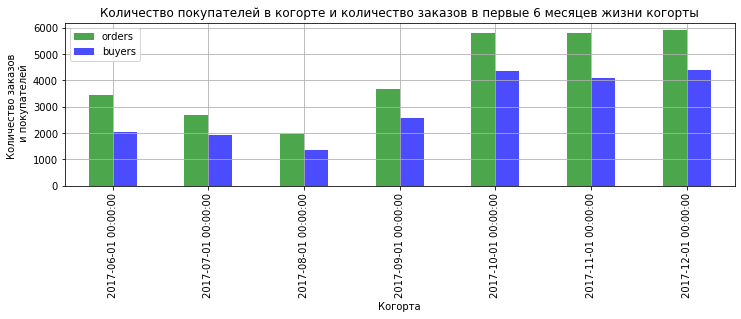

In [101]:
new_orders_by_cohorts = pd.DataFrame(cum_orders_by_cohorts[5])
orders_buyers_by_cohorts = new_orders_by_cohorts.merge(buyers_by_cohorts, on='first_order_month')
orders_buyers_by_cohorts.columns = ['orders', 'buyers']
orders_buyers_by_cohorts.plot(kind='bar', grid=True, alpha=.7, figsize=(12,3), color=['g', 'b'])
plt.title("Количество покупателей в когорте и количество заказов в первые 6 месяцев жизни когорты")
plt.xlabel("Когорта")
plt.ylabel("Количество заказов \n и покупателей")
plt.show()

Видно, что у всех когорт за 6 месяцев заказов примерно на 30-40% больше, чем покупателей.

Объединим таблицы orders_by_cohorts и buyers_by_cohorts по индексам (названию когорт), для этого подходит метод join:

In [102]:
cum_orders_by_cohorts = cum_orders_by_cohorts.join(buyers_by_cohorts)
cum_orders_by_cohorts

,0,1,2,3,4,5,uid
first_order_month,,,,,,,
2017-06-01,2354.0,2531.0,2705.0,2931.0,3223.0,3441.0,2023
2017-07-01,2186.0,2286.0,2406.0,2510.0,2582.0,2664.0,1923
2017-08-01,1533.0,1641.0,1741.0,1822.0,1907.0,1969.0,1370
2017-09-01,2933.0,3152.0,3313.0,3477.0,3544.0,3653.0,2581
2017-10-01,4964.0,5278.0,5440.0,5562.0,5691.0,5794.0,4340
2017-11-01,4813.0,5210.0,5392.0,5603.0,5739.0,5798.0,4081
2017-12-01,5052.0,5322.0,5524.0,5703.0,5789.0,5894.0,4383


Теперь поделим число покупок в каждой ячейке на число покупателей в когорте, а затем удалим уже ненужный столбец с числом покупателей:

In [103]:
lifetimes = list(cum_orders_by_cohorts.columns)
for lifetime in lifetimes[:-1]: # для каждого месяца lifetime
    cum_orders_by_cohorts[lifetime] = (cum_orders_by_cohorts[lifetime] / \
                                           cum_orders_by_cohorts['uid']) # найдём среднее кол-во покупок клиента 
del cum_orders_by_cohorts['uid'] # удалим уже ненужный столбец с количеством покупателей в когорте
cum_orders_by_cohorts

,0,1,2,3,4,5
first_order_month,,,,,,
2017-06-01,1.163618,1.251112,1.337123,1.448838,1.593178,1.700939
2017-07-01,1.136765,1.188768,1.251170,1.305252,1.342694,1.385335
2017-08-01,1.118978,1.197810,1.270803,1.329927,1.391971,1.437226
2017-09-01,1.136381,1.221232,1.283611,1.347152,1.373111,1.415343
2017-10-01,1.143779,1.216129,1.253456,1.281567,1.311290,1.335023
2017-11-01,1.179368,1.276648,1.321245,1.372948,1.406273,1.420730
2017-12-01,1.152635,1.214237,1.260324,1.301164,1.320785,1.344741


Мы получили для каждого месяца жизни среднее накопительное количество заказов на одного покупателя.

Построим тепловую карту:

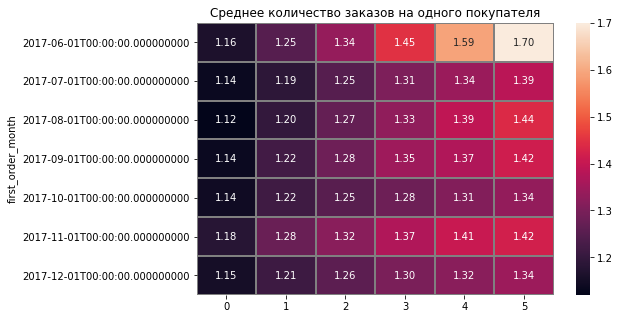

In [104]:
plt.figure(figsize=(8, 5))
plt.title("Среднее количество заказов на одного покупателя")
sns.heatmap(cum_orders_by_cohorts, annot=True, fmt='.2f', linewidths=1, 
            linecolor='gray', vmin=1.12, vmax=1.7)
plt.show()

На тепловой карте мы получили среднее накопительное количество заказов для каждой когорты в 0-5 месяцы lifetime. Мы видим, что:
- в нулевой месяц lifetime значения превосходят 1. Это нормально, так как в этот месяц все клиенты совершили заказ, а некоторые - несколько заказов;
- основная масса заказов совершается в нулевой месяц жизни, в последующие месяцы жизни лишь некоторые клеинты совершают новые заказы. Это видно по тому, как плавно и неспеша растут значения в течение жизни;
- в нулевой месяц все когорты примерно одинаковые - каждый клиент совершает 1,12-1,18 заказов;
- наиболее активной по количеству повторных заказов является первая, июньская, когорта - на 5-й месяц lifetime на одного клиента приходится 1,7 заказов. Во всех других когортах на одного клиента приходится 1,34-1,44 заказов.

Построим столбиковую диаграмму, как меняется среднее количество заказов на одного клиента за 6 месяцев в зависимости от когорты:

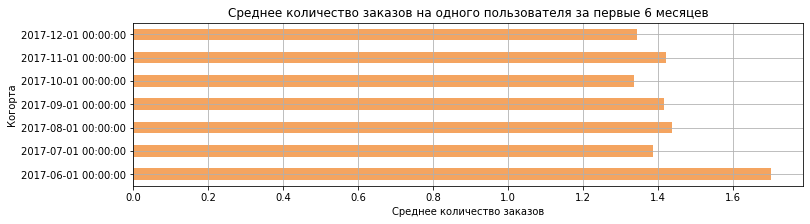

In [105]:
cum_orders_by_cohorts.plot(y=5, kind='barh', figsize=(12,3), grid=True, color='sandybrown', legend=False)
plt.title("Среднее количество заказов на одного пользователя за первые 6 месяцев")
plt.ylabel("Когорта")
plt.xlabel("Среднее количество заказов")
plt.show()

Клиенты из первой, июньской, когорты совершают заказы чаще клиентов в других когортах - 1,70 заказа за первые 6 месяцев жизни против 1,33-1,44 в других когортах.

Усреднённое по когортам количество заказов на одного клиента за 6 месяцев:

In [106]:
cum_orders_by_cohorts[5].mean()

1.4341911542792218

### <a name="15"> Средняя выручка c покупателя </a>

Рассчитаем среднюю выручку с покупателя в каждой когорте. Для этого найдём накопительную выручку для каждой когорты в различные месяцы жизни и затем поделим на количество покупателей в когорте. 

На этот раз посмотрим, как тип устройства влияет на среднюю выручку: проведём общий когортный анализ, анализ для компьютера и для смартфона.

Общий анализ:

In [107]:
revenue_by_cohorts = orders.pivot_table(index='first_order_month', 
                                        columns='lifetime', values='revenue', aggfunc='sum')
cum_revenue_by_cohorts = revenue_by_cohorts.cumsum(axis=1)
cum_revenue_by_cohorts.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,9557.49,10539.3,11424.6,13355.9,15424.5,16912.5,18835.2,20011.8,21130.9,22356.4,23512.1,24031.7
2017-07-01,11557.65,12202.3,13401.3,14091.6,14431.6,14731.7,14962.8,15235.5,15545.6,15828.6,16127.9,
2017-08-01,7228.83,7875.46,8503.58,9039.63,9716.48,10104.9,10393.5,10948.4,11348.7,11606.3,,
2017-09-01,14568.53,17453,18797.5,29059.1,30092.9,31763,33573.8,34201.4,34676.3,,,
2017-10-01,21716.20,24041.4,24872.1,25554.1,26211.8,26734.2,27102.3,27603.4,,,,
2017-11-01,21036.26,22665.5,23479.9,24806,25410.1,25630,26099,,,,,
2017-12-01,20767.49,21908.7,25963.4,30632.5,32004.1,33485.7,,,,,,
2018-01-01,13949.50,14943.7,15970.1,16451.6,16663.1,,,,,,,
2018-02-01,15177.16,16193.1,16479.8,16750.5,,,,,,,,


Добавим столбец с числом пользователей в каждой когорте:

In [108]:
cum_revenue_by_user = cum_revenue_by_cohorts.join(buyers_by_cohorts)

Теперь поделим выручки в каждый период времени на число пользователей в когорте. Так мы узнаем, сколько принёс выручки каждый пользователь когорты в определенный период времени:

In [109]:
lifetimes = cum_revenue_by_user.columns
for lifetime in lifetimes[:-1]: # для каждого месяца lifetime
    cum_revenue_by_user[lifetime] = (cum_revenue_by_user[lifetime] / \
                                           cum_revenue_by_user['uid']) # найдём среднее кол-во покупок клиента 
del cum_revenue_by_user['uid'] # удалим уже ненужный столбец с количеством покупателей в когорте

Чтобы можно было сравнивать когорты между собой, будем смотреть только на когорты в их первые 6 месяцев жизни. Кроме того, среднюю выручку посчитаем накопительным итогом, посмотрим, как она растёт во времени:

In [110]:
cum_revenue_by_user = cum_revenue_by_user.iloc[:7,:6]
cum_revenue_by_user

,0,1,2,3,4,5
first_order_month,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084
2017-07-01,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316
2017-12-01,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913


Построим тепловую карту:

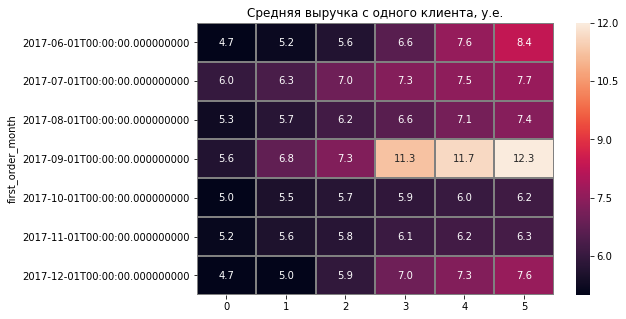

In [111]:
plt.figure(figsize=(8, 5))
plt.title("Средняя выручка с одного клиента, у.е.")
sns.heatmap(cum_revenue_by_user, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin=5, vmax=12)
plt.show()

По тепловой карте видно, что:
- в нулевой месяц lifetime средняя выручка составляет примерно половину от выручки за 6 месяцев. Это связано с тем, что в этот месяц все клиенты совершали сделки. В следующие месяцы большинство клиентов не принесут выручки, поэтому накопленная выручка будет расти не так быстро;
- бросается в глаза выброс у сентябрьской когорты в 3 месяц lifetime - накопленная выручка резко возросла. Видимо кто-то из клиентов когорты совершил крупную покупку в этот месяц.

Построим столбиковую диаграмму, как меняется средняя выручка с одного клиента за первые 6 месяцев в зависимости от когорты:

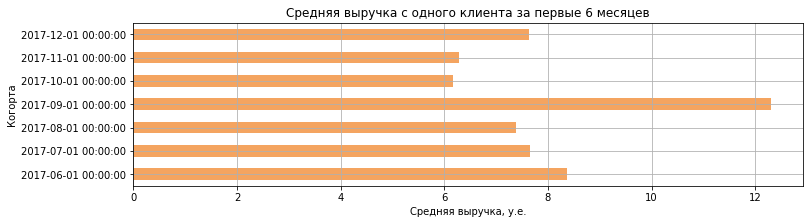

In [112]:
cum_revenue_by_user.plot(y=5, kind='barh', figsize=(12,3), grid=True, color='sandybrown', legend=False)
plt.title("Средняя выручка с одного клиента за первые 6 месяцев")
plt.ylabel("Когорта")
plt.xlabel("Средняя выручка, у.е.")
plt.show()

С заметным отрывом больше всего принесли покупатели из сентябрьской когорты - более 12 у.е. каждый.

Усреднённая по когортам средняя выручка с одного клиента за первые 6 месяцев:

In [113]:
cum_revenue_by_user[5].mean()

7.969052630207336

Анализ для компьютеров и устройств:

Теперь построим такой график в зависимости от типа устройства. Нам понадобится рассчитанная средняя накопленная выручка с одного покупателя за 6 месяцев для когорт в зависимости от устройства. Напишем функцию, которая будет считать её:

In [114]:
def cum_revenue_by_user_by(device):
    revenue_by_user_device = orders.query('device == @device') \
        .pivot_table(index='first_order_month', columns='lifetime', values='revenue', aggfunc='sum')
    cum_revenue_by_user_device = revenue_by_user_device.cumsum(axis=1)
    buyers_by_user_device = orders.query('device == @device').groupby('first_order_month')[['uid']].nunique()
    cum_revenue_by_user_device = cum_revenue_by_user_device.join(buyers_by_user_device)
    lifetimes = cum_revenue_by_user_device.columns
    for lifetime in lifetimes[:-1]:
        cum_revenue_by_user_device[lifetime] = (cum_revenue_by_user_device[lifetime] / \
                                               cum_revenue_by_user_device['uid'])
    del cum_revenue_by_user_device['uid']
    cum_revenue_by_user_device = cum_revenue_by_user_device.iloc[:7,:6]
    return cum_revenue_by_user_device[5]

Теперь посчитаем среднюю накопленную выручку для каждого типа устройств и объединим их по когортам:

In [115]:
touch = cum_revenue_by_user_by("touch").reset_index()
desktop = cum_revenue_by_user_by("desktop").reset_index()
cum_revenue_by_user_by_device = touch.merge(desktop, on='first_order_month')
cum_revenue_by_user_by_device.set_index('first_order_month', inplace=True)
cum_revenue_by_user_by_device.columns = ['touch', 'desktop']

Построим график:

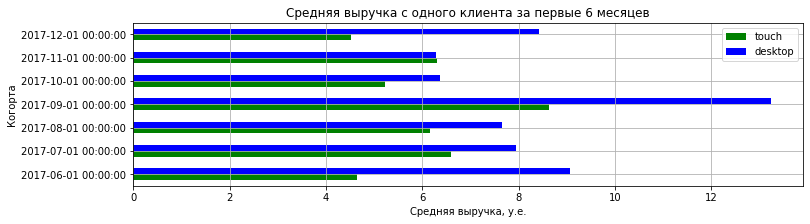

In [116]:
cum_revenue_by_user_by_device.plot(kind='barh', figsize=(12,3), grid=True, color=['g', 'b'])
plt.title("Средняя выручка с одного клиента за первые 6 месяцев")
plt.ylabel("Когорта")
plt.xlabel("Средняя выручка, у.е.")
plt.show()

Практически у всех когорт средняя выручка с покупателя больше для устройств типа desktop. Возможно, что сайт для смартфонов хуже адаптирован для заказов.

### <a name="16"> Средний чек </a>

Рассчитаем, как меняется средняя выручка с заказа (средний чек) для разных когорт в разный период времени, и построим тепловую карту:

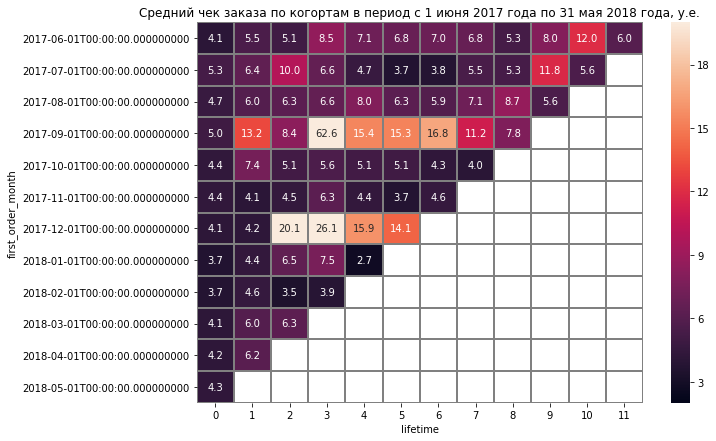

In [117]:
average_check_by_cohorts = orders.pivot_table(index='first_order_month', 
                                        columns='lifetime', values='revenue', aggfunc='mean')
plt.figure(figsize=(10, 7))
plt.title("Средний чек заказа по когортам в период с 1 июня 2017 года по 31 мая 2018 года, у.е.")
sns.heatmap(average_check_by_cohorts, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin=2, vmax=20)
plt.show()

Наблюдения:
- для той же сентябрьской когорты, для которой мы отметили выброс в 4 у.е. средней выручки с пользователя в 3 месяц, наблюдается выброс в размере среднего чека - 62 у.е. Другие выбросы среднего чека наблюдаются у декабрьской когорты - 20 и 26 у.е. Это означает, что в сентябрьской и декабрьской когортах есть клиенты, которые совершают крупные покупки;
- для остальных когорт средний чек колеблется в среднем от 4 до 12 у.е.

Усредним средний чек по когортам:

In [118]:
pd.DataFrame(average_check_by_cohorts.mean(axis=0).round(1)).T

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
0,4.3,6.2,7.6,14.9,7.9,7.9,7.0,6.9,6.8,8.5,8.8,6.0


В течение жизни когорт средний чек растёт. Если в первый месяц у всех когорт он колебался от 4 до 5 у.е., то дальше начал расти. Видимо оставшиеся преданные покупатели начинают тратить больше за один заказ.

Посмотрим, как средний чек зависит от типа устройства. Напишем функцию, которая будет считать средний чек для разных месяцев жизни покупателей в зависимости от устройства:

In [119]:
def average_check_by_cohorts_by(device):
    average_check_by_cohorts_touch = orders.query('device == @device').pivot_table(index='first_order_month', 
                                            columns='lifetime', values='revenue', aggfunc='mean')
    return pd.DataFrame(average_check_by_cohorts_touch.mean(axis=0).round(1)).T

Посмотрим, как меняется средний чек для покупателей со смартфонов:

In [120]:
average_check_by_cohorts_by('touch')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
0,4.1,7.0,5.2,5.1,4.0,4.0,10.2,7.7,4.1,5.1,4.8,12.0


... и компьютеров:

In [121]:
average_check_by_cohorts_by('desktop')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
0,4.4,6.1,7.8,16.5,8.4,8.4,6.4,6.8,7.2,9.3,9.1,5.5


Покупатели с компьютеров делают примерно в два раза более дорогие заказы, чем покупатели со смартфонов. Имеет смысл привлекать таких покупателей активнее.

### <a name="17"> Выводы по метрикам электронной коммерции </a>

На основе изучения метрик электронной коммерции можно сделать следующие выводы:
- среднее время на заказ - почти 17 дней, а медианное - 16 минут. Однако чаще всего посетителям на совершение заказа нужна всего 1 минута;
- среднее количество заказов у одного покупателя за первые 6 месяцев - 1,43. Клиенты, совершившие первый заказ в июне, совершают заказы чаще других клиентов - примерно 1,7 заказа против 1,33-1,44 у других клиентов;
- средняя выручка с одного клиента за первые 6 месяцев - 8 у.е. С заметным отрывом больше всего принесли покупатели из сентябрьской когорты - более 12 у.е. каждый;
- практически у всех когорт средняя выручка с покупателя больше для устройств типа desktop. Возможно, что сайт для смартфонов хуже адаптирован для заказов.
- средний чек колеблется от 4 до 9 у.е., однако встречаются выбросы вплоть до 62 у.е. у сентябрьской когорты в 3 месяц жизни. В течение жизни когорт средний чек плавно растёт - видимо сказывается накопленная лояльность к сайту;
- покупатели с компьютеров делают примерно в два раза более дорогие заказы, чем покупатели со смартфонов. Имеет смысл привлекать таких покупателей активнее.

[К началу](#0)

## <a name="18"> Маркетинговые метрики </a>

В этом разделе мы будем изучать маркетинговые метрики, то есть метрики, связанные с расходами и окупаемостью. Всю достаточную для анализа информацию помимо таблиц visits и orders содержит таблица costs, поэтому будем работать со всеми тремя таблицами.

### <a name="19"> Расходы на маркетинг </a>

Cуммарные расходы на маркетинг и расходы, разделенные по источникам, мы посчитали в самом начале:

In [122]:
total_costs

329131.62

In [123]:
costs_by_sources.T

source_id,1,2,3,4,5,9,10
costs,20833.27,42806.04,141321.63,61073.6,51757.1,5517.49,5822.49


Теперь посмотрим, как расходы на источники клиентов менялись во времени. 

Сейчас в таблице costs дата расходов указана с точностью до дня. С такой детализацией график изменения расходов получится слишком зашумлённым. Поэтому снизим детализацию, добавим столбец с первым днём месяца расходов:

In [124]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]')

Сгруппируем таблицу по источнику клиентов и месяцу расходов, посчитаем суммарные расходы:

In [125]:
costs_by_source = costs.groupby(['source_id', 'costs_month'])['costs'].sum().reset_index()
costs_by_source.head(3)

,source_id,costs_month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81


Построим линейный график маркетинговых расходов на каждый источник клиентов в зависимости от периода времени: 

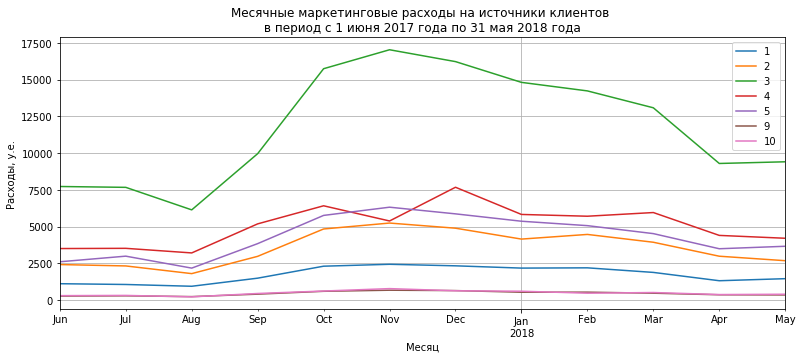

In [126]:
ax = costs_by_source.query('source_id == 1').plot(x='costs_month', y='costs', label='1', figsize=(13,5))
for source in sources_with_costs[1:]:
    costs_by_source.query('source_id == @source').plot(x='costs_month', y='costs', ax=ax, label=source, grid=True)
plt.title("Месячные маркетинговые расходы на источники клиентов \n в период с 1 июня 2017 года по 31 мая 2018 года ")
plt.xlabel("Месяц")
plt.ylabel("Расходы, у.е.")
plt.show()

На протяжении всего года больше всего расходов было на 3 источник. Ранее мы отмечали, что осенью и зимой было больше посетителей на сайте. Теперь видно, что скорее всего это было связано не с сезонностью, а с маркетинговыми расходами.

### <a name="20"> Метрика CAC </a>

Рассчитаем метрику CAC (Customer Acquisition Cost) - определим, сколько стоит привлечение одного покупателя из каждого источника трафика.

Чтобы рассчитать этот параметр, нам нужно в одной таблице собрать число покупателей по источникам, сами источники, выручку и расходы для этих источников.

Для начала составим таблицу с посетителями сайта и их источниками. Сгруппируем таблицу visits по uid и source_id:

In [127]:
visits.groupby(['uid', 'source_id'])[['start_ts']].min().iloc[:,:0]
# столбец start_ts нам на самом деле не нужен, применили расчёт по нему, чтобы реализовать функцию groupby

,
uid,source_id
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5
...,...
18446403737806311543,5
18446424184725333426,4
18446556406699109058,3


У нас получилось 277 870 строк. Проблема в том, что всего уникальных посетителей сайта 228 169 - мы считали это число в самом начале исследования:

In [128]:
total_visitors

228169

Это означает, что есть пользователи, которые пришли из нескольких источников. Чтобы однозначно привязать к каждому посетители только один источник, посмотрим с какого источника клиент пришёл раньше. 

У нас есть таблица first_visits с датами и временем первого посещения для каждого пользователя. Объединим эту таблицу с таблицей visits по uid и first_visit = start_ts. Так мы оставим только те записи таблицы visits, где пользователь впервые посетил сайт. Эта запись хранит нужный нам номер источника. 

In [129]:
first_visits

,uid,first_visit,device
0,11863502262781,2018-03-01 17:27:00,touch
1,49537067089222,2018-02-06 15:55:00,touch
2,297729379853735,2017-06-07 18:47:00,desktop
3,313578113262317,2017-09-18 22:49:00,desktop
4,325320750514679,2017-09-30 14:29:00,desktop
...,...,...,...
228165,18446403737806311543,2017-11-30 03:36:00,desktop
228166,18446424184725333426,2017-12-06 20:32:00,touch
228167,18446556406699109058,2018-01-01 16:29:00,touch
228168,18446621818809592527,2017-12-27 13:27:00,desktop


In [130]:
new_visits = pd.merge(visits, first_visits, 
                      left_on=['uid', 'start_ts', 'device'], right_on=['uid', 'first_visit', 'device'])
new_visits.head(3)

,device,end_ts,source_id,start_ts,uid,visit_date,visit_week,visit_month,session_duration_sec,first_visit_month,lifetime,first_visit
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080,2017-12-01,0,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680,2018-02-01,0,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01,0,2017-07-01 01:54:00


In [131]:
len(new_visits)

228172

Уникальных посетителей 228 169, а записей осталось 228 172 - на три записи больше. Это означает, что один или несколько посетителей пришли на сайт в одно и то же время два или больше разы. Найдём этих посетителей и записи с ними в таблице new_visits:

In [132]:
new_visits.uid.value_counts().head(3)

1981020429381477763     4
15524371937328942332    1
10480844125477879110    1
Name: uid, dtype: int64

In [133]:
new_visits.query('uid == 1981020429381477763')

,device,end_ts,source_id,start_ts,uid,visit_date,visit_week,visit_month,session_duration_sec,first_visit_month,lifetime,first_visit
38692,touch,2018-03-16 08:57:00,1,2018-03-16 08:55:00,1981020429381477763,2018-03-16,2018-03-15,2018-03-01,120,2018-03-01,0,2018-03-16 08:55:00
38693,touch,2018-03-16 08:57:00,1,2018-03-16 08:55:00,1981020429381477763,2018-03-16,2018-03-15,2018-03-01,120,2018-03-01,0,2018-03-16 08:55:00
38694,touch,2018-03-16 08:55:00,1,2018-03-16 08:55:00,1981020429381477763,2018-03-16,2018-03-15,2018-03-01,0,2018-03-01,0,2018-03-16 08:55:00
38695,touch,2018-03-16 08:55:00,1,2018-03-16 08:55:00,1981020429381477763,2018-03-16,2018-03-15,2018-03-01,0,2018-03-01,0,2018-03-16 08:55:00


Этот посетитель пришёл из источника 1 в 4 раза. Выбирать между разными источниками не придётся.

Составим итоговую таблицу с посетителями и их источниками:

In [134]:
uid_sources = new_visits.groupby('uid')[['source_id']].min().reset_index()
uid_sources

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5
...,...,...
228164,18446403737806311543,5
228165,18446424184725333426,4
228166,18446556406699109058,3
228167,18446621818809592527,4


Теперь число строк сходится - у нас есть все 228 169 посетителей и их источники. 

Теперь по каждому клиенту посчитаем выручку, которую он принёс:

In [135]:
uid_revenues = orders.groupby('uid')[['revenue']].sum().reset_index()
uid_revenues

,uid,revenue
0,313578113262317,0.55
1,1575281904278712,3.05
2,2429014661409475,73.33
3,2464366381792757,2.44
4,2551852515556206,10.99
...,...,...
36517,18445147675727495770,3.05
36518,18445407535914413204,0.88
36519,18445601152732270159,4.22
36520,18446156210226471712,9.78


Количество клиентов с заказами 36 522. Изначально мы считали это число и было:

In [136]:
total_buyers

36523

Клиент, которого не хватает - это тот клиент, который оформил заказ 1 июня в 00:02:00. Мы его удалили из таблицы, чтобы не создавать под него когорту. Поэтому все цифры сходятся.

Объединим таблицу с источниками посетителей (uid_sources) с таблицей с выручками (uid_revenues) по uid:

In [137]:
uid_stat = pd.merge(uid_revenues, uid_sources, on='uid')
uid_stat

,uid,revenue,source_id
0,313578113262317,0.55,2
1,1575281904278712,3.05,10
2,2429014661409475,73.33,3
3,2464366381792757,2.44,5
4,2551852515556206,10.99,5
...,...,...,...
36517,18445147675727495770,3.05,5
36518,18445407535914413204,0.88,3
36519,18445601152732270159,4.22,2
36520,18446156210226471712,9.78,3


Теперь объединим эту таблицу с таблицей costs_by_sources, которая содержит суммарные рекламные расходы по источникам: 

In [138]:
new_uid_stat = pd.merge(uid_stat, costs_by_sources, on='source_id')
new_uid_stat

,uid,revenue,source_id,costs
0,313578113262317,0.55,2,42806.04
1,3605148382144603,0.69,2,42806.04
2,6339315367323360,1.04,2,42806.04
3,15930622431697628,3.67,2,42806.04
4,19133919191467791,7.40,2,42806.04
...,...,...,...,...
36516,18355739313865661478,0.89,9,5517.49
36517,18371076119082624883,1.28,9,5517.49
36518,18398730194181111194,0.61,9,5517.49
36519,18427985941394855399,3.05,9,5517.49


После объединения пропал один покупатель: было 36 522, стало 36 521. Так как мы объединяли таблицы по source_id, то возможно где-то не совпали источники. Выведем все источники, с которых к нам приходили покупатели, и все источники, на которые у нас были расходы:

In [139]:
sources_with_buyers = uid_stat.source_id.unique()
sources_with_buyers.sort()
sources_with_buyers

array([ 1,  2,  3,  4,  5,  7,  9, 10])

In [140]:
sources_with_costs

array([ 1,  2,  3,  4,  5,  9, 10])

Среди покупателей есть клиент, который пришёл от 7 источника. Среди источников с расходами такого источника нет. Найдём этого покупателя:

In [141]:
uid_stat.query('source_id == 7')

,uid,revenue,source_id
22521,11377414203346034748,1.22,7


Так как на 7 источник не было рекламных расходов, то мы не сможем корректно считать для него CAC. Поэтому то, что он исчезает из нашей итоговой таблицы new_uid_stat - это нормально. 

Составим список с источниками и посетителями:

In [142]:
# удаляем 6 и 7 источники, т.к. по ним не было рекламных расходов
visitors_by_sources = uid_sources.groupby('source_id')['uid'].nunique().drop([6, 7]) 
visitors_by_sources.name = 'visitors'
visitors_by_sources

source_id
1      9469
2     17616
3     66116
4     72346
5     49237
9      6448
10     6903
Name: visitors, dtype: int64

Сгруппируем таблицу по источникам и посчитаем количество покупателей и посетителей, конверсию посетителей в покупателей, выручку, расходы и баланс (сальдо), возврат на рекламные расходы (ROMI), стоимость привлечения покупателя (CAC), среднюю выручку с покупателя и разницу между выручкой и CAC:

In [143]:
sources_stat = new_uid_stat.groupby('source_id').\
                        agg({'uid': 'nunique', 'revenue': 'sum', 'costs': 'mean'})
sources_stat['balance'] = sources_stat['revenue'] - sources_stat['costs']
sources_stat['romi'] = sources_stat['revenue'] / sources_stat['costs']
sources_stat = sources_stat.join(visitors_by_sources)
sources_stat['convertion'] = sources_stat['uid'] / sources_stat['visitors']
sources_stat['cac'] = sources_stat['costs'] / sources_stat['uid']
sources_stat['revenue_per_buyer'] = sources_stat['revenue'] / sources_stat['uid']
sources_stat['delta_revenue_cac'] = sources_stat['revenue_per_buyer'] - sources_stat['cac']
sources_stat.loc['sum']= sources_stat.sum()
sources_stat = sources_stat.rename(columns={'uid': 'buyers'})
sources_stat

,buyers,revenue,costs,balance,romi,visitors,convertion,cac,revenue_per_buyer,delta_revenue_cac
source_id,,,,,,,,,,
1,2899.0,31090.55,20833.27,10257.28,1.492351,9469.0,0.306157,7.186364,10.724577,3.538213
2,3506.0,46923.61,42806.04,4117.57,1.096191,17616.0,0.199024,12.209367,13.383802,1.174435
3,10473.0,54511.24,141321.63,-86810.39,0.385725,66116.0,0.158403,13.493901,5.204931,-8.288971
4,10295.0,56693.41,61073.60,-4380.19,0.928280,72346.0,0.142302,5.932356,5.506888,-0.425468
5,6931.0,52624.02,51757.10,866.92,1.016750,49237.0,0.140768,7.467479,7.592558,0.125079
9,1088.0,5759.40,5517.49,241.91,1.043844,6448.0,0.168734,5.071222,5.293566,0.222344
10,1329.0,4450.33,5822.49,-1372.16,0.764335,6903.0,0.192525,4.381106,3.348631,-1.032476
sum,36521.0,252052.56,329131.62,-77079.06,6.727476,228135.0,1.307914,55.741796,51.054953,-4.686843


Проверим, что сошлись все суммы по количеству покупателей, суммарной выручке и суммарным расходам. Выведем ранее расчитанные эти значения:

In [144]:
total_buyers, total_revenue, total_costs, total_visitors

(36523, 252057.19999999998, 329131.62, 228169)

В нашей таблице: 
- количество покупателей на два меньше. Мы про них помним: один покупатель из 7 источника, второй - купил в июне 2018. Они не должны были попасть в таблицу;
- суммарная выручка немного меньше - это как раз связано с неучитанной выручкой от двух неучтённых покупателей;
- суммарные расходы точно сошлись - нигде ничего не потеряли;
- количество посетителей по источникам немного меньше - это связано с тем, что мы исключили посетителей из 6 и 7 источников.

Сравним визуально, как CAC меняется в зависимости от источника клиентов:


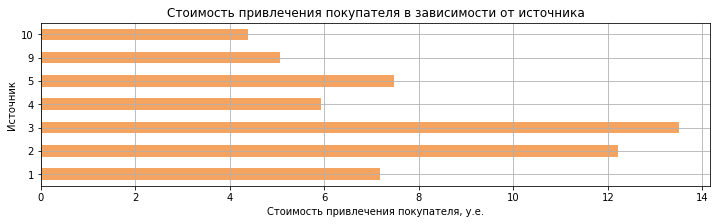

In [145]:
sources_stat.iloc[:-1,:].plot(y='cac', kind='barh', figsize=(12,3), grid=True, color='sandybrown', legend=False)
plt.title("Стоимость привлечения покупателя в зависимости от источника")
plt.xlabel("Стоимость привлечения покупателя, у.е.")
plt.ylabel("Источник")
plt.show()

3 источник оказался самым дорогим: один покупатель стоит больше 13 у.е. Возможно поэтому он и не окупается. Однако, если источник очень дешёвый, то это не гарантия, что он окупится, Пример этому - источник 10. Он тоже не окупается. 
    
2 источник также дорогой, но его покупатели приносят большую выручку. За счёт этого он окупается. Это пример того, что источники, пусть и дорогие, могут приносить клиентов с деньгами, которые будут делать дорогие заказы.

Построим диаграмму с количеством посетителей и покупателей для каждого источника, на который у нас были расходы:

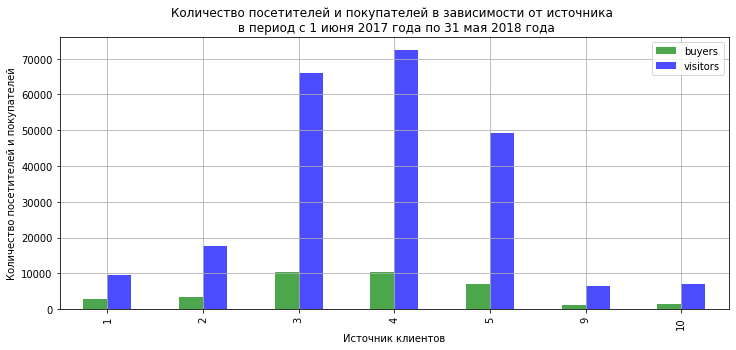

In [146]:
sources_stat.iloc[:-1,0::5].plot(kind='bar', grid=True, alpha=.7, figsize=(12,5), color=['g', 'b'])
plt.title("Количество посетителей и покупателей в зависимости от источника \n в период с 1 июня 2017 года по 31 мая 2018 года")
plt.xlabel("Источник клиентов")
plt.ylabel("Количество посетителей и покупателей")
plt.show()

Построим диаграмму с выручкой и рекламными расходами для каждого источника:

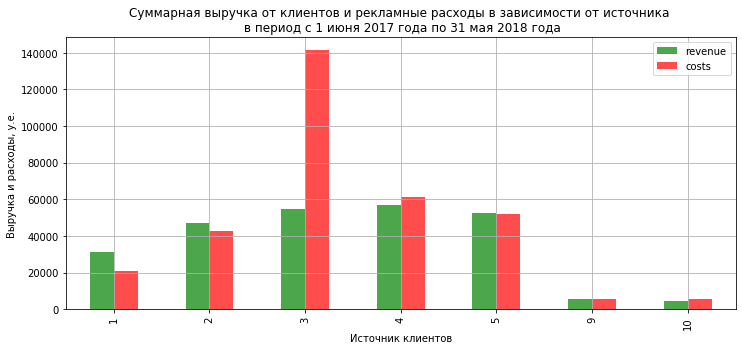

In [147]:
sources_stat.iloc[:-1,1:3].plot(kind='bar', grid=True, alpha=.7, figsize=(12,5), color=['g', 'r'])
plt.title("Суммарная выручка от клиентов и рекламные расходы в зависимости от источника \n в период \
с 1 июня 2017 года по 31 мая 2018 года")
plt.xlabel("Источник клиентов")
plt.ylabel("Выручка и расходы, у.е.")
plt.show()

Можно сделать следующие выводы:
- принесли выручку только 1 и 2 источники, едва окупились 5 и 9, оказались убыточными 3, 4 и 10. Акцент в расходах был сделан на 3 источник и ставка не сыграла - его ROMI менее 40%;
- на 5 источник было потрачено в 2,5 раза меньше средств, чем на 3 источник, однако он принёс примерно столько же выручки;
- наилучшая коверсия посетителей в покупателей у 1 источника - 31%. ROMI также у него самый высокий - 149%. Ставку нужно делать на этот исчтоник - тратить больше средств на его рекламу.


Посмотрим, как менялся CAC для разных источников в зависимости от месяца. Поделим таблицу с суммарными расходами по месяцам на таблицу с количеством привлечённых покупателей по месяцам. 
    
Сначала составим таблицу с расходами по месяцам в зависимости от источника:


In [148]:
costs_by_sources_by_month = costs_by_source.pivot_table(index='costs_month', columns='source_id'
                                                        , values='costs', aggfunc='mean')
costs_by_sources_by_month

source_id,1,2,3,4,5,9,10
costs_month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


Теперь составим таблицу с количеством привлечённых покупателей по месяцам в зависимости от источника. Для этого нужно будет составить таблицу, где для каждого uid будут значения first_order_month (есть в таблице orders) и source_id (есть в таблице new_uid_stat). Объединим таблицы orders и new_uid_stat по uid. Затем развернём получившуюся таблицу так, чтобы по строкам были месяцы, когда пришли покупатели, по столбцам - источники, а в ячейках - количество пришедших покупателей:

In [149]:
buyers_sources_month = pd.merge(orders, new_uid_stat, on='uid')
buyers_by_sources_by_month = buyers_sources_month.pivot_table(index='first_order_month', columns='source_id', 
                                            values='uid', aggfunc='nunique')
buyers_by_sources_by_month

source_id,1,2,3,4,5,9,10
first_order_month,,,,,,,
2017-06-01,190,235,638,413,384,68,95
2017-07-01,160,208,512,517,423,52,51
2017-08-01,113,123,337,338,360,61,37
2017-09-01,227,221,781,590,589,87,86
2017-10-01,340,396,1152,1172,945,126,209
2017-11-01,324,398,1216,1177,693,145,128
2017-12-01,331,381,1317,1377,771,121,85
2018-01-01,238,292,1006,1032,633,80,92
2018-02-01,275,293,1092,1106,678,84,123


Теперь поделим таблицу с расходами на таблицу с покупателями. Выведем результат в виде тепловой карты:


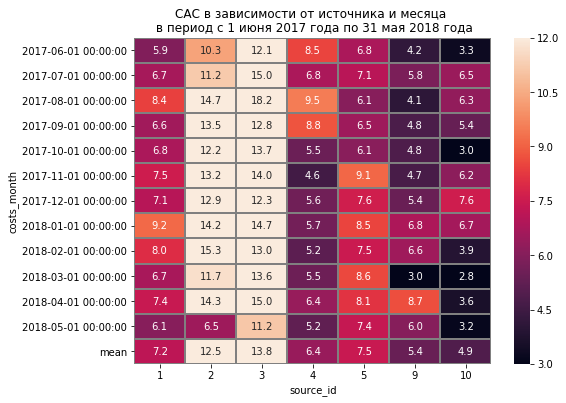

In [150]:
cac_by_sources_by_month = costs_by_sources_by_month / buyers_by_sources_by_month
cac_by_sources_by_month.loc['mean']= cac_by_sources_by_month.mean()
plt.figure(figsize=(8, 6))
plt.title("CAC в зависимости от источника и месяца \n в период с 1 июня 2017 года по 31 мая 2018 года")
sns.heatmap(cac_by_sources_by_month, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin=3, vmax=12)
plt.show()

Можно проверить расчёты на этой карте следующим образом: сравним средние значения по месяцам (уже посчитаны, нижняя строчка на тепловой карте) с тем, что мы считали в таблице sources_stat:

In [151]:
sources_stat[['cac']].T

source_id,1,2,3,4,5,9,10,sum
cac,7.186364,12.209367,13.493901,5.932356,7.467479,5.071222,4.381106,55.741796


Значения немного расходятся, но в целом они совпадают. Погрешность вызвана тем, что в таблице sources_stat мы делили общие расходы на источник на общее количество покупателей от источника, а в таблице cac_by_sources_by_month мы сначала делили расходы за месяц на количество покупателей за месяц, а потом усредняли значение по месяцам.

По тепловой карте видно, что:
- 2 и 3 источники всегда были относительно дорогими в плане привлечения покупателей. 2 по крайней мере окупается, а 3 совсем печальный;   
- у 4 источника CAC в последние месяцы начал уменьшаться. Если CAC будет оставаться минимальным в будущие месяцы, источник может стать прибыльным (пока он убыточный).


### <a name="21"> Метрика ROMI </a>

Посчитаем возврат на маркетинговые расходы (ROMI) для каждой когорты покупателей в зависимости от источника.

Добавим в таблицу с заказами orders для каждого покупателя его источник из таблицы uid_sources:

In [152]:
new_orders = pd.merge(orders, uid_sources, on='uid')
new_orders.head(3)

,buy_ts,revenue,uid,device,first_order,first_order_month,order_month,lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2


Теперь найдём рекламные расходы для каждого источника для каждого месяца. Для этого таблицу с расходами costs сгруппируем по источнику и месяцу расходов и посчитаем суммарные расходы:

In [153]:
costs_grouped = costs.groupby(['source_id', 'costs_month'])[['costs']].sum()
costs_grouped

costs
source_id costs_month         
1         2017-06-01   1125.61
          2017-07-01   1072.88
          2017-08-01    951.81
          2017-09-01   1502.01
          2017-10-01   2315.75
...                        ...
10        2018-01-01    614.35
          2018-02-01    480.88
          2018-03-01    526.41
          2018-04-01    388.25
          2018-05-01    409.86

[84 rows x 1 columns]

Добавим в таблицу new_orders столбец с расходами на источник в первый месяц заказа покупателя. Сохраним таблицу под именем orders_costs. Затем поделим все выручки с заказов (столбец revenue) на расходы на источник в первый месяц покупки этого покупателя ( столбец costs) и сохраним в столбце romi. Так мы получим долю, которую каждый заказ возвращает от вложенных в источник расходов:

In [154]:
orders_costs = pd.merge(new_orders, costs_grouped, 
                  left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])
orders_costs['romi'] = orders_costs['revenue'] / orders_costs['costs']
orders_costs

,buy_ts,revenue,uid,device,first_order,first_order_month,order_month,lifetime,source_id,costs,romi
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1,1125.61,0.015103
1,2017-06-01 09:22:00,1.22,3644482766749211722,desktop,2017-06-01 09:22:00,2017-06-01,2017-06-01,0,1,1125.61,0.001084
2,2017-06-02 12:44:00,0.85,3644482766749211722,desktop,2017-06-01 09:22:00,2017-06-01,2017-06-01,0,1,1125.61,0.000755
3,2017-06-02 15:08:00,12.83,3644482766749211722,desktop,2017-06-01 09:22:00,2017-06-01,2017-06-01,0,1,1125.61,0.011398
4,2017-06-04 13:06:00,17.11,3644482766749211722,desktop,2017-06-01 09:22:00,2017-06-01,2017-06-01,0,1,1125.61,0.015201
...,...,...,...,...,...,...,...,...,...,...,...
50408,2018-05-31 15:26:00,2.14,5832940207941651411,desktop,2018-05-31 15:26:00,2018-05-01,2018-05-01,0,9,362.17,0.005909
50409,2018-05-31 16:06:00,4.89,14372027836561602167,desktop,2018-05-31 16:06:00,2018-05-01,2018-05-01,0,9,362.17,0.013502
50410,2018-05-31 17:20:00,3.42,13465334080837783919,desktop,2018-05-31 17:20:00,2018-05-01,2018-05-01,0,9,362.17,0.009443
50411,2018-05-31 18:22:00,0.92,5359718846599854608,touch,2018-05-31 18:22:00,2018-05-01,2018-05-01,0,9,362.17,0.002540


Осталось 50 413 заказов - это верное значение. Изначально было 50 415 заказов, но, как мы помним, один заказ был в июне 2018 года и мы его удалили, а второй заказ - покупателя от 7 источника, и он не попадает в таблицу, так как на 7 источник не было маркетинговых расходов.

Теперь напишем цикл: для каждого источника клиентов, на который были рекламные расходы (переменная sources_with_costs), рассчитаем накопительный ROMI по когортам покупателей и усреднённый накопительный ROMI для всех когорт:

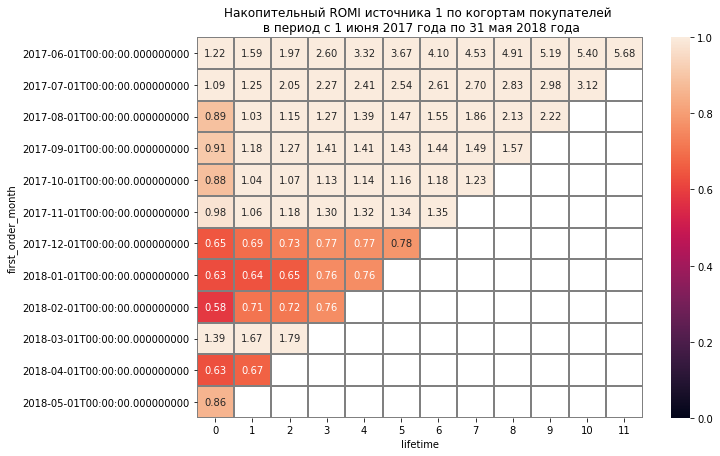

Накопительный ROMI источника 1 (усреднённый по когортам)


lifetime,0,1,2,3,4,5,6,7,8,9,10,11
0,0.89,1.05,1.26,1.36,1.57,1.77,2.04,2.36,2.86,3.46,4.26,5.68


----------------------------------------------------------------------------------------


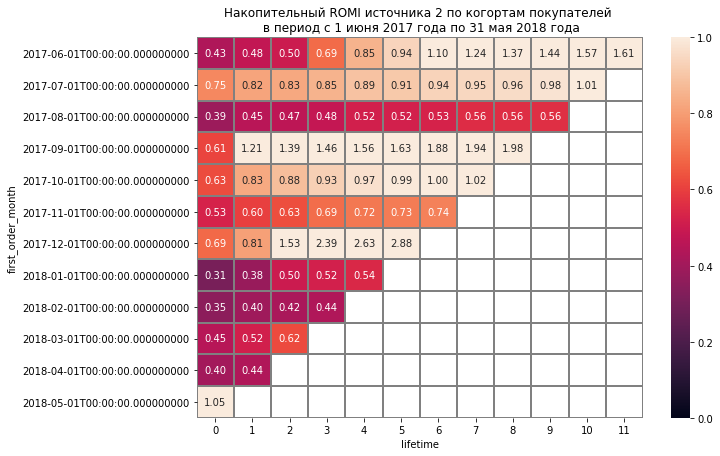

Накопительный ROMI источника 2 (усреднённый по когортам)


lifetime,0,1,2,3,4,5,6,7,8,9,10,11
0,0.55,0.63,0.78,0.94,1.09,1.23,1.03,1.14,1.22,0.99,1.29,1.61


----------------------------------------------------------------------------------------


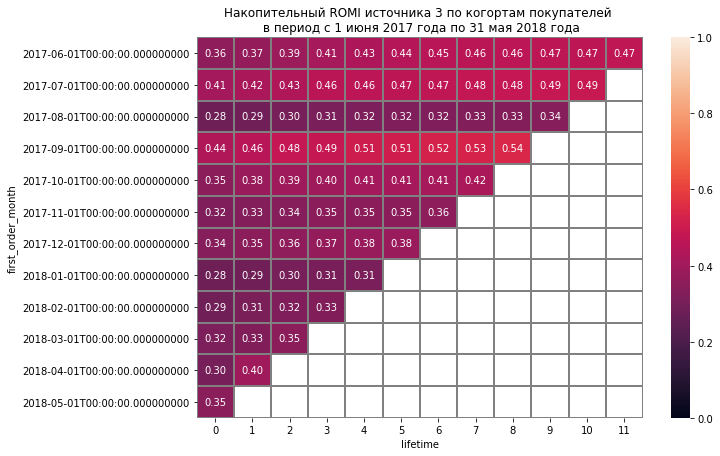

Накопительный ROMI источника 3 (усреднённый по когортам)


lifetime,0,1,2,3,4,5,6,7,8,9,10,11
0,0.34,0.36,0.37,0.38,0.39,0.41,0.42,0.44,0.45,0.43,0.48,0.47


----------------------------------------------------------------------------------------


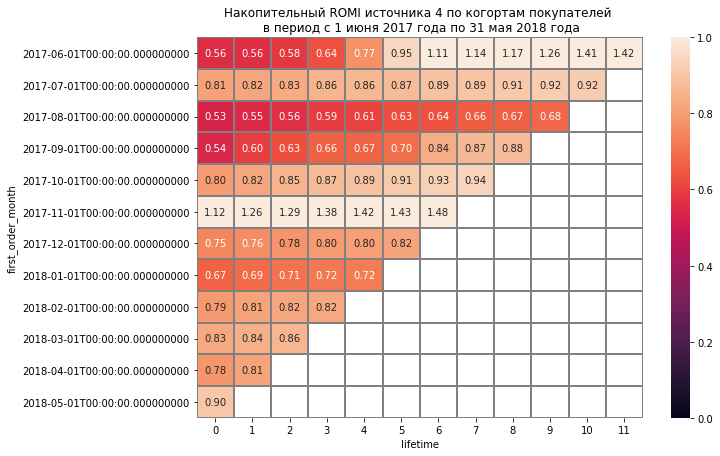

Накопительный ROMI источника 4 (усреднённый по когортам)


lifetime,0,1,2,3,4,5,6,7,8,9,10,11
0,0.76,0.78,0.79,0.81,0.84,0.9,0.98,0.9,0.9,0.95,1.17,1.42


----------------------------------------------------------------------------------------


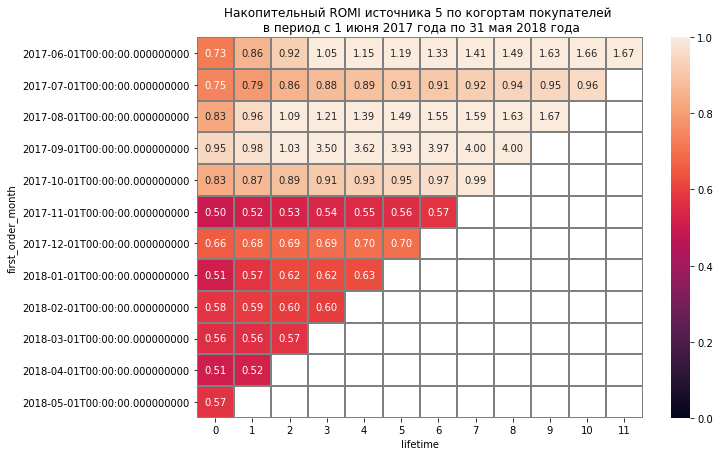

Накопительный ROMI источника 5 (усреднённый по когортам)


lifetime,0,1,2,3,4,5,6,7,8,9,10,11
0,0.66,0.72,0.78,1.11,1.23,1.39,1.55,1.78,2.02,1.42,1.31,1.67


----------------------------------------------------------------------------------------


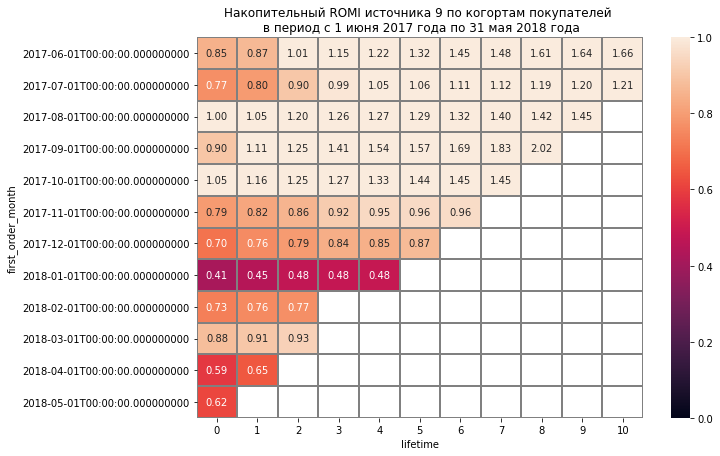

Накопительный ROMI источника 9 (усреднённый по когортам)


lifetime,0,1,2,3,4,5,6,7,8,9,10
0,0.77,0.85,0.94,1.04,1.09,1.22,1.33,1.46,1.56,1.43,1.43


----------------------------------------------------------------------------------------


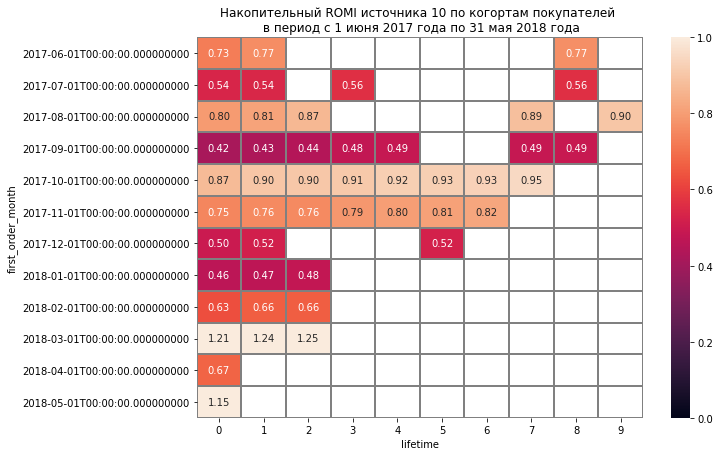

Накопительный ROMI источника 10 (усреднённый по когортам)


lifetime,0,1,2,3,4,5,6,7,8,9
0,0.73,0.71,0.77,0.69,0.74,0.75,0.88,0.77,0.61,0.9


----------------------------------------------------------------------------------------


In [155]:
for source in sources_with_costs: # для каждого источника, на который были расходы
    # составим сводную таблицу с когортами, месяцами жизни и накопительным ROMI
    source_romi = orders_costs.query('source_id == @source').pivot_table(index='first_order_month',
                                        columns='lifetime', values='romi', aggfunc='sum').cumsum(axis=1)
    # построим тепловую карту, все окупившиеся когорты будут подсвечены самым ярким цветом
    plt.figure(figsize=(10, 7))
    plt.title(f"Накопительный ROMI источника {source} по когортам покупателей \n в период с 1 июня 2017 года \
по 31 мая 2018 года")
    sns.heatmap(source_romi, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=0, vmax=1)
    plt.show()
    # рассчитаем усреднённый накопительный ROMI для всех когорт
    print(f'Накопительный ROMI источника {source} (усреднённый по когортам)')
    display(pd.DataFrame(source_romi.mean(axis=0).round(2)).T)
    print('----------------------------------------------------------------------------------------')

По тепловым картам можно сделать следующие выводы об источниках клиентов:
- источник 1:
  - когорты с июньской по октябрьскую окупились, причем июньская когорта окупилась почти 6 раз;
  - более поздние когорты (не считая мартовской) пока не успели окупиться - скорее всего им пока просто не хватило времени;
  - мартовская когорта также окупилась, причем уже с нулевого месяца жизни;
  - в среднем когорты окупаются уже на 1 месяц lifetime;
  
- источник 2:
  - когорты окупаются не так бодро, как у источника 1 - в среднем только на 4 месяц lifetime;
  - однако последняя, майская, когорта окупилась уже в 0 месяц lifetime;
  - есть явно неудачная, августовская, когорта - она за 10 месяцев окупилась лишь на 56%;
  
- источник 3:
  - самый неудачный источник - ни одна когорта не окупилась;
  - лучший результат у сентябрьской когорты - 0,54;
  
- источник 4:
  - в среднем когорты окупаются лишь на 10 месяц lifetime;
  - январьская когорта окупилась сразу6 в нулевой месяц lifetime;
  - как и у источника 2, августовская когорта самая неудачная - за 10 месяцев лишь 68%;
  
- источник 5:
  - в среднем когорты окупаются на 3 месяц lifetime;
  - однако июльская когорта за 11 месяцев так и не окупилась;
  - зато сентябрьская когорта окупилась 4 раза;
  
- источник 9:
  - в среднем когорты окупаются также на 3 месяц lifetime;
  - не у всех когорт есть сделки в каждый месяц жизни, например, у майской когорты не было сделок в 11 месяц lifetime, а у февральской - в 3 месяц lifetime;
  
- источник 10:
  - в среднем когорты не окупаются;
  - лишь мартовская и майская когорты окупились, причем в нулевой месяц lifetime;
  - у многих когорт пропуски в сделках в разные месяцы жизни - отчасти это связано с небольшим количеством покупателей от этого источника (хотя покупателей от источника 9 было еще меньше), отчасти - с тем, видимо, что заказы совершали неравномерно.

Таким образом, самый прибыльный источник - 1 - расходы окупаются в 1 месяц жизни. Неплохие 2, 5 и 9 источники окупаются на 3-4 месяц жизни. 4 источник оказался средним - расходы окупаются лишь через 11 месяцев, почти через год. Убыточные источники - 3 и 10 - расходы не окупаются за 12 месяцев.

### <a name="22"> Выводы по маркетинговым метрикам </a>

На основе изучения маркетинговых метрик можно сделать следующие выводы:
- на протяжении всего года больше всего расходов было на 3 источник. Ранее мы отмечали, что осенью и зимой было больше посетителей на сайте. Теперь понятно, что это было связано не с сезонностью, а с динамикой маркетинговых расходов в течение года;
- 3 источник оказался самым дорогим: один покупатель стоит больше 13 у.е. Возможно поэтому он и не окупается. Однако, если источник очень дешёвый, то это не гарантия, что он окупится. Пример этому - источник 10. Он не окупается;
- пока принесли выручку только 1 и 2 источники, едва окупились 5 и 9, оказались убыточными 3, 4 и 10. Акцент в расходах был сделан на 3 источник и ставка не сыграла - его ROMI менее 40%;
- наилучшая коверсия посетителей в покупателей у 1 источника - 31%. ROMI также у него самый высокий - 149%. Ставку нужно делать на этот исчтоник - тратить больше средств на его рекламу.

[К началу](#0)

## <a name="23"> Общий вывод и рекомендации </a>

По итогам проведённого исследования можно сделать следующие выводы:
- среднее значение DAU составляет 907, WAU - 5724, MAU - 23 228;
- среднее количество посещений сайта пользователем в сутки - 1,09 раз;
- средняя продолжительность сессии на сайте (ASL) составляет почти 11 минут, медианная - 5 минут. Но чаще всего посетители проводят на сайте 1 минуту;
- среднее время на заказ - почти 17 дней, а медианное - 16 минут. Однако чаще всего посетителям на совершение заказа нужна всего 1 минута;
- среднее количество заказов у одного покупателя за первые 6 месяцев - 1,43;
- средняя выручка с одного клиента за первые 6 месяцев - 8 у.е.;
- средний чек колеблется от 4 до 9 у.е.;
- пока принесли выручку только 1 и 2 источники, едва окупились 5 и 9, оказались убыточными 3, 4 и 10. Акцент в расходах был сделан на 3 источник и ставка не сыграла - его ROMI менее 40%;
- CAC колеблется от 4 до 13 у.е. в зависимости от источника. Источник 3 оказался самым дорогим, возможно поэтому он и не окупается. Однако, если источник очень дешёвый, то это не гарантия, что он окупится. Пример этому - источник 10: он тоже не окупается.

Рекомендации для отдела маркетинга:
- прекратить маркетинговые расходы на 3 и 10 источники - они не окупаются и за год;
- сделать ставку на источник 1: у него наилучшая коверсия посетителей в покупателей - 31%. ROMI за год также у него самый высокий - 149%. Расходы на него окупаются уже в 1 месяц жизни покупателей;
- помимо источника 1 вкладываться в рекламу в источниках 2, 5 и 9: они окупаются примерно на 3-4 месяц жизни покупателей;
- продолжить вкладываться в источник 4: он пока не окупается, но CAC заметно падает от месяца к месяцу. У источника есть потенциал стать прибыльным;
- привлекать больше клиентов с устройств desktop: у них выше и средняя выручка за 6 месяцев, и средний чек по сравнению с покупателями с устройств touch. Либо понять, с чем это связано - возможно нужно улучшить мобильную версию сайта;
- привлекать больше покупателей в июне и сентябре: клиенты июньской когорты совершают 1,7 заказа за первые 6 месяцев жизни против 1,33-1,44 в других когортах, а клиенты сентябрьской когорты принесят наибольшую выручку - более 12 у.е. каждый за первые 6 месяцев жизни.

Замечания к данным, о которых следует сообщить инженерам:
- в таблице visits нет данных о посещениях сайта за 1 апреля. Имеет смысл проверить, с чем это связано;
- продолжительность сессии имеет нетипичную метку в 19 секунд (в основном измеряется минутами). Возможно это баг. Имеет смысл проверить, данные о времени завершения сессии в таблице visits.

[К началу](#0)